# Goal: 
In this project, we will explore the pizza transaction dataset using various techniques, including many supervised learning algorithms (listed below).
The goal is to analyze and model total quantity sold by weekly of specific pizza w specific size in New Jersey based on different category features.
the result we want is the predicting total sales/ quantity for the next year by each pizza and sizes. We will do it by aggregating weekly predictions to get annual forecasts  

---
To predict the quantity sold based on categorical features, several prediction models can be considered. The choice of model depends on the nature of the data and the specific problem requirements. Here are some suitable models for handling categorical features:

1. Linear Models with Regularization:
Lasso Regression (L1 regularization): Helps in feature selection by shrinking less important feature coefficients to zero.
Ridge Regression (L2 regularization): Regularizes model complexity by shrinking coefficients without setting them to zero.
Advantages:
Good for datasets with many categorical variables, especially if one-hot encoding leads to a high-dimensional space.
Efficient and interpretable.

2. Decision Tree Regression:
Handles both numerical and categorical data natively.
Can capture non-linear relationships and interactions between features.
Advantages:
Intuitive and easy to interpret.
No need for extensive preprocessing of categorical data.

3. Random Forest Regression:
An ensemble of decision trees, which improves generalization by reducing variance.
Handles categorical features well and is robust to overfitting.
Advantages:
High accuracy and can capture complex patterns.
Feature importance can be derived, providing insights into the impact of different features.

4. Gradient Boosting Machines (GBM):
Handle categorical features effectively.
Advantages:
Excellent predictive performance.
Built-in handling for categorical features.

5. Support Vector Machines (SVM):
Can be used with kernels to capture non-linear relationships.
Requires preprocessing of categorical data into numerical format (e.g., one-hot encoding).
Advantages:
Effective for both linear and non-linear data.
Robust to overfitting in high-dimensional spaces.


# Dataset: 


We will use a modified version of the pizza dataset. The variables of the dataset are:

Field	        Description

order_id:	    Unique identifier for each order placed by a table

date:	        Date the order was placed (entered into the system prior to cooking & serving)

time:	        Time the order was placed (entered into the system prior to cooking & serving)

quantity:	    Quantity ordered for each pizza of the same type and size

pizza_id:	    Unique identifier for each pizza (constituted by its type and size)

size:	        Size of the pizza (Small, Medium, Large, X Large, or XX Large)

price:	        Price of the pizza in USD

name:	        Name of the pizza as shown in the menu

category:	    Category that the pizza fall under in the menu (Classic, Chicken, Supreme, or Veggie)

ingredients:	Comma-delimited ingredients used in the pizza as shown in the menu (they all include Mozzarella Cheese, even if not specified; and they all include Tomato Sauce, unless another sauce is specified)

To achieve predicting goal, we need to prepare suitable data for models. The dataset need to comprises features such as name, size, price, season, etc... and the target variable is the total quantity sold by week. The dataset unit (that is, each row in the dataset) corresponds to a week by specific pizza name and specific size.  


# Import neccessary libraries 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold
import prince



# <span style="color:green">Reading the dataset</span>

Read the dataset using the provided file in github: data_pizza.xlsx

The dataset has 48,620 rows and 10 columns (3 numeric variable, 5 categorical variables and 2 datetime variables)

We need to prepare the dataset with: 4823 rows and 8 columns (include 5 categorical variables, 2 integer, and 1 target variables as mentioned above)

## D1 Exploratory data analysis and preprocessing.

- Change data types
- check for missing data
- Check for duplicate rows
- Standardize Text Columns
- Get New Jersey and US holidays for the year 2015
- Determine the season based on the date

In [4]:
# Step: Load the dataset
df = pd.read_excel('data_pizza.xlsx')

# Step: Convert 'time' to string format before concatenation
df['time'] = df['time'].astype(str)

# Step: Concatenate 'date' and 'time' into a single column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'], errors='coerce')

# Step: Split 'datetime' into separate 'date' and 'time' columns
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

# change data type
# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ensure 'quantity' is an integer
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

# Ensure 'price' is a float
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Ensure categorical columns are of type 'category'
categorical_columns = ['pizza_id', 'size', 'name', 'category']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Ensure 'ingredients' is treated as a string (if not already)
df['ingredients'] = df['ingredients'].astype(str)
print(df.dtypes)
print("------------------------")

# check for missing data
print(df.isnull().sum())
print("--------------------------")

# Check for duplicate rows
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

# Standardize Text Columns
df['category'] = df['category'].str.strip().str.title()  # Strip spaces and title case
df['size'] = df['size'].str.strip().str.upper()  # Uniform size codes

# Calculate Total Sales (price * quantity)
df['total_sales'] = df['price'] * df['quantity']
print("-------------------------------")
print(df.head(3))

# check for missing data
print(df.isnull().sum())

# Check for duplicate rows
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

# Standardize Text Columns
df['category'] = df['category'].str.strip().str.title()  # Strip spaces and title case
df['size'] = df['size'].str.strip().str.upper()  # Uniform size codes

# Convert Dates and Times:
df['day_of_week'] = pd.to_datetime(df['datetime']).dt.day_name()
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df['month'] = df['date'].dt.month         # Extract month (1 to 12)
df['week_of_year'] = df['date'].dt.isocalendar().week  # Extract week of the year (1 to 52/53)
df['day_of_month'] = df['date'].dt.day    # Extract day of the month (1 to 31)

# Get New Jersey holidays for the year 2015
nj_holidays = holidays.US(years=2015, state='NJ')

# Extract the holiday dates
holiday_dates = list(nj_holidays.keys())  # List of holiday dates

# Create a new 'is_holiday' column by checking if the date is in the holidays list
df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)

# Calculate Total Sales (price * quantity)
df['total_sales'] = df['price'] * df['quantity']

# -----------

# Get US holidays for the year 2015 (or other relevant years)
us_holidays = holidays.US(years=2015, state='NJ')

# Define additional custom holidays
custom_holidays = {
    'St. Patrick’s Day': '2015-03-17',
    'Cesar Chavez Day': '2015-03-31',
    'Yom Kippur Start': '2015-09-22',
    'Yom Kippur End': '2015-09-23',
    'Christmas Day': '2015-12-25',
    'Valentine’s Day': '2015-02-14',
    'Halloween': '2015-10-31',
    'New Year’s Eve': '2015-12-31',
    'Black Friday': '2015-11-27',
    'Easter Sunday': '2015-04-05'
}

# Convert custom holidays to a datetime list
custom_holiday_dates = pd.to_datetime(list(custom_holidays.values()))

# Combine the default US holidays and custom holidays, ensuring all are in the same format
all_holidays = pd.to_datetime(list(us_holidays.keys())).union(custom_holiday_dates)

# Create a new 'is_custom_holiday' column
df['is_custom_holiday'] = df['date'].isin(all_holidays).astype(int)

# Print the first few rows to verify
print(df[['date', 'is_custom_holiday']].head())

# Print all custom holiday dates to verify
print("All custom holidays added:")
print(sorted(all_holidays))

#-----------------

# Define a function to determine the season based on the date
def get_season(date):
    if (date >= pd.Timestamp(date.year, 12, 21)) or (date <= pd.Timestamp(date.year, 3, 19)):
        return 'Winter'
    elif (date >= pd.Timestamp(date.year, 3, 20)) and (date <= pd.Timestamp(date.year, 6, 20)):
        return 'Spring'
    elif (date >= pd.Timestamp(date.year, 6, 21)) and (date <= pd.Timestamp(date.year, 9, 21)):
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to the 'date' column
df['season'] = df['date'].apply(get_season)

# Display the first few rows to verify the new column
print(df[['date', 'season']].head())


order_id                int64
date           datetime64[ns]
time                   object
pizza_id             category
quantity                int64
size                 category
price                 float64
name                 category
category             category
ingredients            object
datetime       datetime64[ns]
dtype: object
------------------------
order_id       0
date           0
time           0
pizza_id       0
quantity       0
size           0
price          0
name           0
category       0
ingredients    0
datetime       0
dtype: int64
--------------------------
Number of duplicate rows: 0
-------------------------------
   order_id       date      time    pizza_id  quantity size  price  \
0         2 2015-01-01  11:57:40  thai_ckn_l         1    L  20.75   
1        16 2015-01-01  13:34:07  thai_ckn_l         1    L  20.75   
2        25 2015-01-01  14:44:44  thai_ckn_l         1    L  20.75   

                     name category  \
0  The Thai Chicken Pizza

C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\3110747526.py:76: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)


        date  is_custom_holiday
0 2015-01-01                  1
1 2015-01-01                  1
2 2015-01-01                  1
3 2015-01-01                  1
4 2015-01-01                  1
All custom holidays added:
[Timestamp('2015-01-01 00:00:00'), Timestamp('2015-01-19 00:00:00'), Timestamp('2015-02-12 00:00:00'), Timestamp('2015-02-14 00:00:00'), Timestamp('2015-02-16 00:00:00'), Timestamp('2015-03-17 00:00:00'), Timestamp('2015-03-31 00:00:00'), Timestamp('2015-04-03 00:00:00'), Timestamp('2015-04-05 00:00:00'), Timestamp('2015-05-25 00:00:00'), Timestamp('2015-07-03 00:00:00'), Timestamp('2015-07-04 00:00:00'), Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-22 00:00:00'), Timestamp('2015-09-23 00:00:00'), Timestamp('2015-10-12 00:00:00'), Timestamp('2015-10-31 00:00:00'), Timestamp('2015-11-11 00:00:00'), Timestamp('2015-11-26 00:00:00'), Timestamp('2015-11-27 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2015-12-31 00:00:00')]
        date  season
0 2015-01-0

In [5]:
# checking dataset
df.dtypes

order_id                      int64
date                 datetime64[ns]
time                         object
pizza_id                   category
quantity                      int64
size                         object
price                       float64
name                       category
category                     object
ingredients                  object
datetime             datetime64[ns]
total_sales                 float64
day_of_week                  object
hour                          int32
month                         int32
week_of_year                 UInt32
day_of_month                  int32
is_holiday                    int64
is_custom_holiday             int64
season                       object
dtype: object

In [6]:
# Aggregate by Week and Pizza Name + Size:
# Aggregate by week
weekly_sales = df.groupby(['name', 'size', 'week_of_year']).agg(
    total_quantity_sold_W=('quantity', 'sum'),
    price=('price', 'first')
).reset_index()

#---
#  Holiday Flag
# The transform('max') approach will mark the week or month as a holiday if there is at least one day marked as a holiday.

# For weekly sales
weekly_sales['is_holiday_week'] = df.groupby('week_of_year')['is_custom_holiday'].transform('max')

#----
# assign the season for each week or month.
# For weekly sales
weekly_sales['season'] = df.groupby('week_of_year')['season'].transform('first')


C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\2570374601.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_sales = df.groupby(['name', 'size', 'week_of_year']).agg(


In [7]:
# Categorizing the price into ranges (e.g., Low, Medium, High) might help the model understand how the price range impacts sales.
def price_category(price):
    if price < 15:
        return 'Low'
    elif 15 <= price < 25:
        return 'Medium'
    else:
        return 'High'

# Apply to the weekly and monthly datasets
weekly_sales['price_category'] = weekly_sales['price'].apply(price_category)


In [8]:
#-------
# adjust data type
# for weekly sales data
weekly_sales['size'] = weekly_sales['size'].astype('category')
weekly_sales['season'] = weekly_sales['season'].astype('category')
weekly_sales['price_category'] = weekly_sales['price_category'].astype('category')
weekly_sales['is_holiday_week'] = weekly_sales['is_holiday_week'].astype('category')


In [9]:
# checking data types
weekly_sales.dtypes

name                     category
size                     category
week_of_year               UInt32
total_quantity_sold_W       int64
price                     float64
is_holiday_week          category
season                   category
price_category           category
dtype: object

In [10]:
# Get the unique values of the price column
print(weekly_sales['price'].unique())

# --- the dataset shows  some NaN in price column, so we need to do the step below
# check which pizza has NaN price

# Group by name and size to get the unique price for each combination
unique_pizza_prices = weekly_sales.groupby(['name', 'size'])['price'].first().reset_index()

print(unique_pizza_prices)
# We found out that the dataset show 160 rows (32 pizza * 5 sizes) -- BUT NOT ALL PIZZA HAS ALL 5 SIZES, 
# SOME ONLY HAS 1 SIZE, SOME HAS 3 AND A FEW HAS 5 SIZES. 

# we need to filter out, remove the pizza with uncorrect size (below)
# then assign correct price for NaN pizza -> can know which pizza is low on specific week/ month/ season (below)


[20.75 16.75 12.75   nan 12.   23.65 20.25 16.25 12.25 20.5  16.   18.5
 17.95 14.75 25.5  35.95 16.5  13.25 10.5  12.5  21.   15.25  9.75 17.5
 14.5  11.  ]
                                  name size  price
0           The Barbecue Chicken Pizza    L  20.75
1           The Barbecue Chicken Pizza    M  16.75
2           The Barbecue Chicken Pizza    S  12.75
3           The Barbecue Chicken Pizza   XL    NaN
4           The Barbecue Chicken Pizza  XXL    NaN
..                                 ...  ...    ...
155  The Vegetables + Vegetables Pizza    L  20.25
156  The Vegetables + Vegetables Pizza    M  16.00
157  The Vegetables + Vegetables Pizza    S  12.00
158  The Vegetables + Vegetables Pizza   XL    NaN
159  The Vegetables + Vegetables Pizza  XXL    NaN

[160 rows x 3 columns]


C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\205464160.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_pizza_prices = weekly_sales.groupby(['name', 'size'])['price'].first().reset_index()


In [11]:
# now we need to filter out, remove the pizza with uncorrect size

# weekly
# Step: Identify valid name and size combinations
valid_combinations = df[['name', 'size']].drop_duplicates()

# Step: Create a set of valid combinations for faster lookup
valid_combinations_set = set([tuple(x) for x in valid_combinations.to_numpy()])

# Step: Filter the weekly_sales dataset
filtered_weekly_sales = weekly_sales[
    weekly_sales.apply(lambda row: (row['name'], row['size']) in valid_combinations_set, axis=1)
]

# Optional: Reset index after filtering
filtered_weekly_sales.reset_index(drop=True, inplace=True)

# Print the filtered dataset
print(filtered_weekly_sales)


                                   name size  week_of_year  \
0            The Barbecue Chicken Pizza    L             1   
1            The Barbecue Chicken Pizza    L             2   
2            The Barbecue Chicken Pizza    L             3   
3            The Barbecue Chicken Pizza    L             4   
4            The Barbecue Chicken Pizza    L             5   
...                                 ...  ...           ...   
4818  The Vegetables + Vegetables Pizza    S            49   
4819  The Vegetables + Vegetables Pizza    S            50   
4820  The Vegetables + Vegetables Pizza    S            51   
4821  The Vegetables + Vegetables Pizza    S            52   
4822  The Vegetables + Vegetables Pizza    S            53   

      total_quantity_sold_W  price is_holiday_week  season price_category  
0                        18  20.75               1  Winter         Medium  
1                        13  20.75               1  Winter         Medium  
2                        25

In [12]:
# Check for rows where 'price' column is NaN
nan_price_rows = filtered_weekly_sales[filtered_weekly_sales['price'].isna()]

# Print the rows with NaN values in 'price' column
print(nan_price_rows)


                           name size  week_of_year  total_quantity_sold_W  \
265         The Calabrese Pizza    L             1                      0   
375         The Calabrese Pizza    S             5                      0   
377         The Calabrese Pizza    S             7                      0   
380         The Calabrese Pizza    S            10                      0   
402         The Calabrese Pizza    S            32                      0   
...                         ...  ...           ...                    ...   
3604      The Soppressata Pizza    M             1                      0   
3657      The Soppressata Pizza    S             1                      0   
4041    The Spinach Pesto Pizza    L            14                      0   
4273  The Spinach Supreme Pizza    M            34                      0   
4345  The Spinach Supreme Pizza    S            53                      0   

      price is_holiday_week  season price_category  
265     NaN           

In [13]:
# assign correct price for NaN pizza 
# -> can know which pizza is low on specific week/ month/ season

# weekly
# Step: Create a mapping of unique (name, size) combinations and their prices
price_mapping = df[['name', 'size', 'price']].drop_duplicates()
price_mapping

# Step: Create a dictionary for lookups
price_dict = price_mapping.set_index(['name', 'size'])['price'].to_dict()

# Step: Assign prices to the filtered dataset
filtered_weekly_sales['price'] = filtered_weekly_sales.apply(
    lambda row: price_dict.get((row['name'], row['size']), np.nan),
    axis=1
)

# Step: Print the updated dataset to verify
print(filtered_weekly_sales)

                                   name size  week_of_year  \
0            The Barbecue Chicken Pizza    L             1   
1            The Barbecue Chicken Pizza    L             2   
2            The Barbecue Chicken Pizza    L             3   
3            The Barbecue Chicken Pizza    L             4   
4            The Barbecue Chicken Pizza    L             5   
...                                 ...  ...           ...   
4818  The Vegetables + Vegetables Pizza    S            49   
4819  The Vegetables + Vegetables Pizza    S            50   
4820  The Vegetables + Vegetables Pizza    S            51   
4821  The Vegetables + Vegetables Pizza    S            52   
4822  The Vegetables + Vegetables Pizza    S            53   

      total_quantity_sold_W  price is_holiday_week  season price_category  
0                        18  20.75               1  Winter         Medium  
1                        13  20.75               1  Winter         Medium  
2                        25

C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\2668615250.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weekly_sales['price'] = filtered_weekly_sales.apply(


In [14]:
# check again
print(filtered_weekly_sales['price'].unique())

[20.75 16.75 12.75 12.   23.65 20.25 16.25 12.25 20.5  16.   18.5  17.95
 14.75 25.5  35.95 16.5  13.25 10.5  12.5  21.   15.25  9.75 17.5  14.5
 11.  ]


## Visualizing Categorical Data

### 1. Check the distribution of total_quantity_sold_W, and check for imbalance in categorical features:

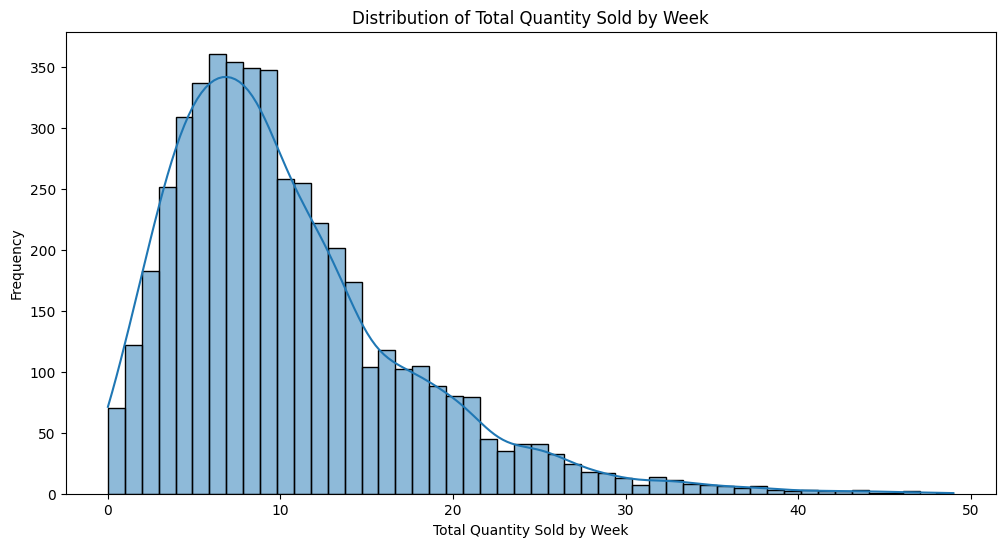

In [15]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the distribution of the total quantity sold by week
sns.histplot(filtered_weekly_sales['total_quantity_sold_W'], kde=True, bins=50)

# Set the title and labels
plt.title('Distribution of Total Quantity Sold by Week')
plt.xlabel('Total Quantity Sold by Week')
plt.ylabel('Frequency')

# Show the plot
plt.show()


- Data seems to represent a natural sales pattern and skew left

- Since the data’s skew reflects a natural sales pattern, and our goal is to predict quantities, we likely don’t need to balance or adjust the data, but we may try log transformations if our model struggles with prediction accuracy.

### 2. Visualize the distribution of categories with target variable with Bar Plots

C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\1136648267.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order=filtered_weekly_sales.groupby('name')['total_quantity_sold_W'].sum().sort_values(ascending=False).index,
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\1136648267.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


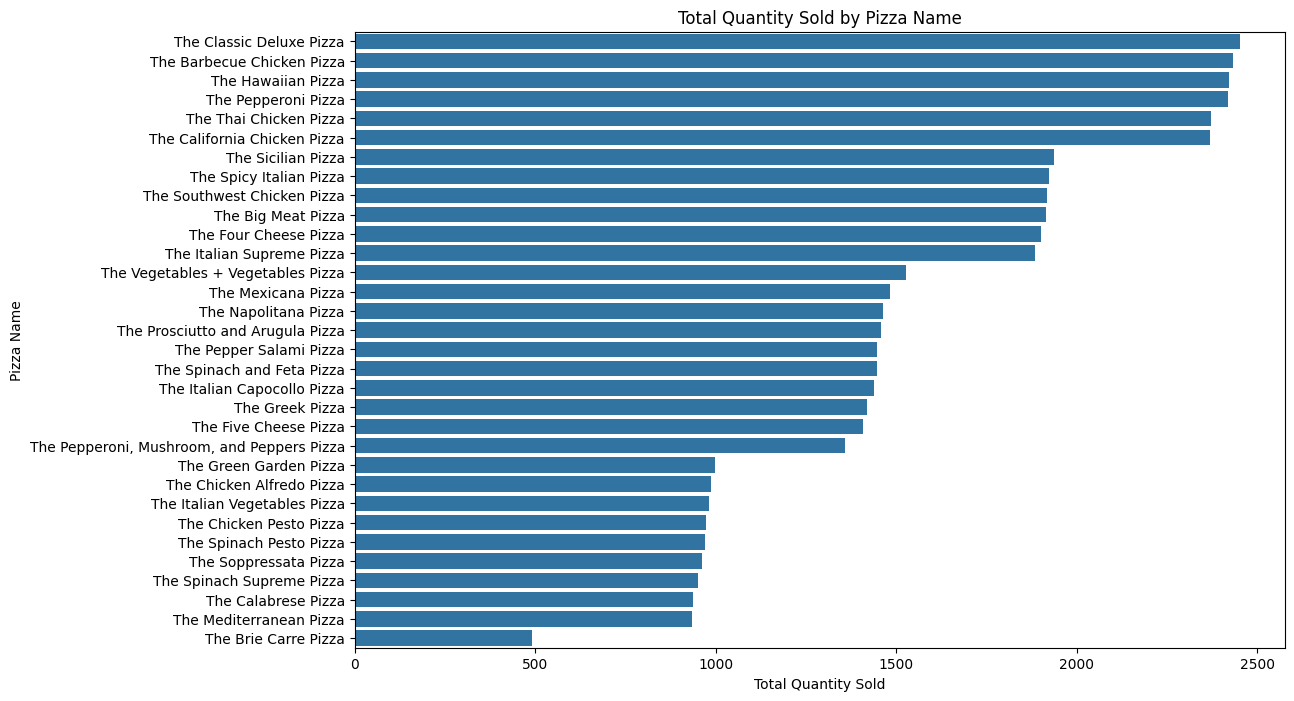

In [16]:
# Plot for 'name' vs 'total_quantity_sold_W' (this plot will be outside the grid, so we handle it separately)
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed for better readability
sns.barplot(
    x='total_quantity_sold_W', 
    y='name', 
    data=filtered_weekly_sales, 
    estimator=sum, 
    ci=None, 
    order=filtered_weekly_sales.groupby('name')['total_quantity_sold_W'].sum().sort_values(ascending=False).index,
    orient='h'  # Horizontal orientation
)
plt.title('Total Quantity Sold by Pizza Name')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

- top 6 pizza around 2400-2500 quantity sold: the classic deluxe pizza > the bbq chicken pizza> the hawaiian pizza > the pepperoni pizza > the thai chicken pizza > the california chicken pizza 
- bottom pizza around 500 quantity sold: the bire carre pizza.
- other pizza around nearly 1000-2000 quantity sold.

C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\3997221868.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='size', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[0, 0])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\3997221868.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='is_holiday_week', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[0, 1])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\3997221868.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[1, 0])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\3997221868.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same 

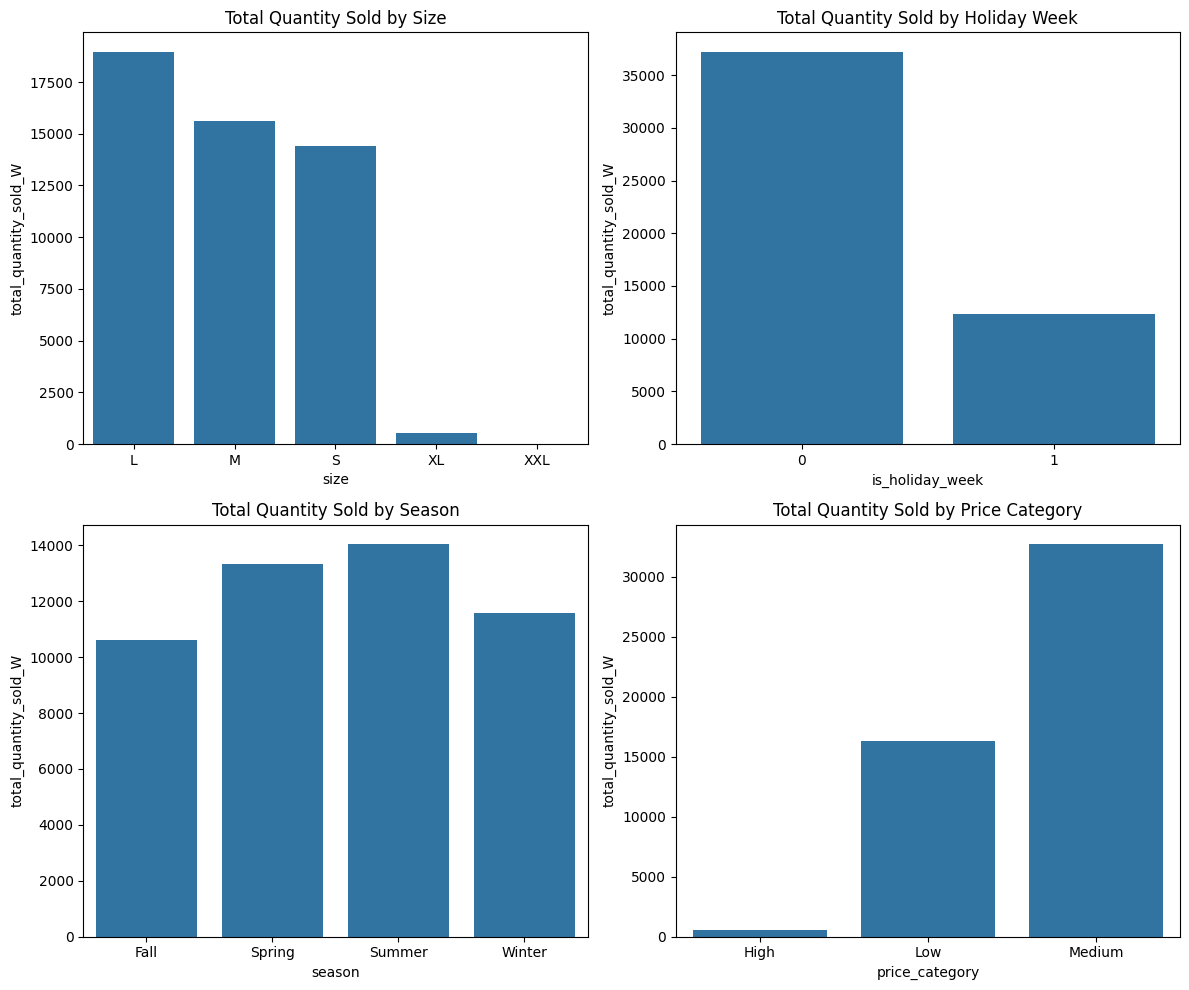

In [17]:
# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed for better readability

# Plot for 'size' vs 'total_quantity_sold_W'
sns.barplot(x='size', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[0, 0])
axes[0, 0].set_title('Total Quantity Sold by Size')

# Plot for 'is_holiday_week' vs 'total_quantity_sold_W'
sns.barplot(x='is_holiday_week', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[0, 1])
axes[0, 1].set_title('Total Quantity Sold by Holiday Week')

# Plot for 'season' vs 'total_quantity_sold_W'
sns.barplot(x='season', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[1, 0])
axes[1, 0].set_title('Total Quantity Sold by Season')

# Plot for 'price_category' vs 'total_quantity_sold_W'
sns.barplot(x='price_category', y='total_quantity_sold_W', data=filtered_weekly_sales, estimator=sum, ci=None, ax=axes[1, 1])
axes[1, 1].set_title('Total Quantity Sold by Price Category')

# Adjust layout to make sure everything fits well
plt.tight_layout()
plt.show()


- quantity sold by size: L>M>S>XL>XXL
- non-holiday sold more than holiday around 2.7 times
- Quantity sold by season: summer>spring>winter>fall (14K>13.5K>11.8K>10.5K)
- Quantity sold by price: medium price around $15-$25> low price below $15 > high price above $25 (30K>15K>500)

# <span style="color:green">Analysing the impact of different data transformations</span>

Create two versions of the dataset as described below:

Remember to properly encode the categorical variable by creating l−1 new
binary/dummy variables, where l is the number of categories of the variable.

The original dataset (that is, with the new dummy variables, removing the categorical
variable, and without any other changing the features). We will refer to this version as
data1.

The dataset with the transformation in the target variable: Apply the log transformation to the target variable (total_quantity_sold_W). Thus, we will keep all the
original predictor variables (same features as data1) and update the target variable. This
version will be referred to as data2.

In [18]:
# Perform one-hot encoding without dropping any category

# name variale
name_dummies = pd.get_dummies(filtered_weekly_sales['name'], prefix='name', drop_first=False)
# Manually drop the 'The Barbecue Chicken Pizza' dummy variable
name_dummies.drop('name_The Barbecue Chicken Pizza', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
name_dummies = name_dummies.astype(int)

# size variable
size_dummies = pd.get_dummies(filtered_weekly_sales['size'], prefix='size', drop_first=False)
# Manually drop the 'L' dummy variable
size_dummies.drop('size_L', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
size_dummies = size_dummies.astype(int)

# season variable
season_dummies = pd.get_dummies(filtered_weekly_sales['season'], prefix='season', drop_first=False)
# Manually drop the 'Fall' dummy variable
season_dummies.drop('season_Fall', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
season_dummies = season_dummies.astype(int)

# price_category variable
price_cate_dummies = pd.get_dummies(filtered_weekly_sales['price_category'], prefix='price_category', drop_first=False)
# Manually drop the 'High' dummy variable
price_cate_dummies.drop('price_category_High', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
price_cate_dummies = price_cate_dummies.astype(int)

# is_holiday_week variable
holiday_dummies = pd.get_dummies(filtered_weekly_sales['is_holiday_week'], prefix='is_holiday_week', drop_first=False)
# Manually drop the '0' dummy variable
holiday_dummies.drop('is_holiday_week_0', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
holiday_dummies = holiday_dummies.astype(int)

# ----------
# Concatenate the dummy variables with the original DataFrame
data1_W = pd.concat([filtered_weekly_sales, name_dummies], axis=1)
data1_W = pd.concat([data1_W, size_dummies], axis=1)
data1_W = pd.concat([data1_W, season_dummies], axis=1)
data1_W = pd.concat([data1_W, price_cate_dummies], axis=1)
data1_W = pd.concat([data1_W, holiday_dummies], axis=1)

# Drop the original categorical columns
data1_W.drop(['name', 'size', 'season', 'price_category', 'is_holiday_week'], axis=1, inplace=True)

# Now 'data1_W' contains the original features along with the one-hot encoded features


In [19]:
data1_W.dtypes

week_of_year                                        UInt32
total_quantity_sold_W                                int64
price                                              float64
name_The Big Meat Pizza                              int64
name_The Brie Carre Pizza                            int64
name_The Calabrese Pizza                             int64
name_The California Chicken Pizza                    int64
name_The Chicken Alfredo Pizza                       int64
name_The Chicken Pesto Pizza                         int64
name_The Classic Deluxe Pizza                        int64
name_The Five Cheese Pizza                           int64
name_The Four Cheese Pizza                           int64
name_The Greek Pizza                                 int64
name_The Green Garden Pizza                          int64
name_The Hawaiian Pizza                              int64
name_The Italian Capocollo Pizza                     int64
name_The Italian Supreme Pizza                       int

In [20]:
# Create data2 by copying data1
data2_W = data1_W.copy()

# Apply log transformation to the target variable (total_quantity_sold_W)
data2_W['total_quantity_sold_W'] = np.log1p(data2_W['total_quantity_sold_W'])

# Verify the transformation
print(data2_W[['total_quantity_sold_W']].head())


   total_quantity_sold_W
0               2.944439
1               2.639057
2               3.258097
3               2.772589
4               3.401197


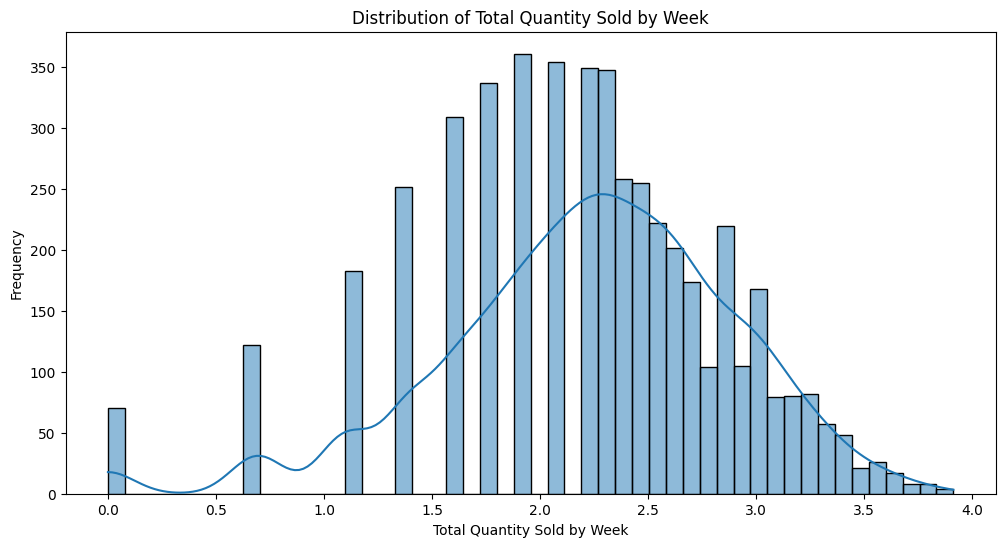

In [21]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the distribution of the total quantity sold by week
sns.histplot(data2_W['total_quantity_sold_W'], kde=True, bins=50)

# Set the title and labels
plt.title('Distribution of Total Quantity Sold by Week')
plt.xlabel('Total Quantity Sold by Week')
plt.ylabel('Frequency')

# Show the plot
plt.show()


## D2

Split each of these two datasets into training and test sets, using 80% of the data for training. Remember to set the random generator’s state to the value “5508” for the splitting function. Fit two models in each dataset: a linear regression model and a Lasso regression model with α = 100. Standardised both datasets appropriately (transforming the features to have zero mean and unit standard deviation). Thus, we provide results for the original and standardised version of data1 and for the original and standardised version of data2.

In [22]:
# Define target and predictors
X1 = data1_W.drop('total_quantity_sold_W', axis=1)
y1 = data1_W['total_quantity_sold_W']
X2 = data2_W.drop('total_quantity_sold_W', axis=1)
y2 = data2_W['total_quantity_sold_W']

# Split datasets into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=5508)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=5508)

class ScaleNumericExceptOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_prefixes):
        self.one_hot_prefixes = one_hot_prefixes
        self.scaler = StandardScaler()
        self.cols_to_scale = None

    def fit(self, X):
        # Identify numeric columns
        numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
        
        # Identify one-hot encoded columns based on provided prefixes
        one_hot_cols = [col for col in X.columns if any(col.startswith(prefix) for prefix in self.one_hot_prefixes)]
        
        # Columns to scale are numeric columns excluding the one-hot encoded columns
        self.cols_to_scale = [col for col in numeric_cols if col not in one_hot_cols]
        
        # Fit the scaler on the columns to scale
        self.scaler.fit(X[self.cols_to_scale])
        return self

    def transform(self, X):
        # Transform the columns to scale
        X_copy = X.copy()
        X_copy[self.cols_to_scale] = self.scaler.transform(X_copy[self.cols_to_scale])
        return X_copy

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# Define the prefixes or patterns that identify the one-hot encoded columns
one_hot_prefixes = ['name_', 'size_', 'season_', 'price_category_', 'is_holiday_week_']

# Initialize the transformer with the one-hot prefixes
scale_numeric_data = ScaleNumericExceptOneHot(one_hot_prefixes=one_hot_prefixes)

# Usage:
# Assuming X1_train and X1_test are your training and test data DataFrames
X1_train_scaled = scale_numeric_data.fit_transform(X1_train)
X1_test_scaled = scale_numeric_data.transform(X1_test)

X2_train_scaled = scale_numeric_data.fit_transform(X2_train)
X2_test_scaled = scale_numeric_data.transform(X2_test)


In [23]:
# Define and train models on original data1
linear_regression_data1 = LinearRegression()
lasso_regression_data1 = Lasso(alpha=100)  

lr_data1 = linear_regression_data1.fit(X1_train, y1_train)
ls_data1 = lasso_regression_data1.fit(X1_train, y1_train)

y1_train_pred_lr = lr_data1.predict(X1_train)
y1_test_pred_lr = lr_data1.predict(X1_test)
y1_train_pred_lasso = ls_data1.predict(X1_train)
y1_test_pred_lasso = ls_data1.predict(X1_test)

rmse_train_lr_data1 = np.sqrt(mean_squared_error(y1_train, y1_train_pred_lr))
rmse_test_lr_data1 = np.sqrt(mean_squared_error(y1_test, y1_test_pred_lr))
rmse_train_lasso_data1 = np.sqrt(mean_squared_error(y1_train, y1_train_pred_lasso))
rmse_test_lasso_data1 = np.sqrt(mean_squared_error(y1_test, y1_test_pred_lasso))

In [24]:
# Define and train models on standardized data1
linear_regression_data1_scaled = LinearRegression()
lasso_regression_data1_scaled = Lasso(alpha=100)

lr_std_data1 = linear_regression_data1_scaled.fit(X1_train_scaled, y1_train)
ls_std_data1 = lasso_regression_data1_scaled.fit(X1_train_scaled, y1_train)

y1_train_pred_lr_scaled = lr_std_data1.predict(X1_train_scaled)
y1_test_pred_lr_scaled = lr_std_data1.predict(X1_test_scaled)
y1_train_pred_lasso_scaled = ls_std_data1.predict(X1_train_scaled)
y1_test_pred_lasso_scaled = ls_std_data1.predict(X1_test_scaled)

rmse_train_lr_data1_scaled = np.sqrt(mean_squared_error(y1_train, y1_train_pred_lr_scaled))
rmse_test_lr_data1_scaled = np.sqrt(mean_squared_error(y1_test, y1_test_pred_lr_scaled))
rmse_train_lasso_data1_scaled = np.sqrt(mean_squared_error(y1_train, y1_train_pred_lasso_scaled))
rmse_test_lasso_data1_scaled = np.sqrt(mean_squared_error(y1_test, y1_test_pred_lasso_scaled))

In [25]:
# Define and train models on original data2
linear_regression_data2 = LinearRegression()
lasso_regression_data2 = Lasso(alpha=100)

lr_data2 = linear_regression_data2.fit(X2_train, y2_train)
ls_data2 = lasso_regression_data2.fit(X2_train, y2_train)

y2_train_pred_lr = lr_data2.predict(X2_train)
y2_test_pred_lr = lr_data2.predict(X2_test)
y2_train_pred_lasso = ls_data2.predict(X2_train)
y2_test_pred_lasso = ls_data2.predict(X2_test)

rmse_train_lr_data2 = np.sqrt(mean_squared_error(y2_train, y2_train_pred_lr))
rmse_test_lr_data2 = np.sqrt(mean_squared_error(y2_test, y2_test_pred_lr))
rmse_train_lasso_data2 = np.sqrt(mean_squared_error(y2_train, y2_train_pred_lasso))
rmse_test_lasso_data2 = np.sqrt(mean_squared_error(y2_test, y2_test_pred_lasso))

In [26]:
# Define and train models on standardized data2
linear_regression_data2_scaled = LinearRegression()
lasso_regression_data2_scaled = Lasso(alpha=100)

lr_std_data2 = linear_regression_data2_scaled.fit(X2_train_scaled, y2_train)
ls_std_data2 = ls_std_data2 = lasso_regression_data2_scaled.fit(X2_train_scaled, y2_train)

y2_train_pred_lr_scaled = lr_std_data2.predict(X2_train_scaled)
y2_test_pred_lr_scaled = lr_std_data2.predict(X2_test_scaled)
y2_train_pred_lasso_scaled = ls_std_data2.predict(X2_train_scaled)
y2_test_pred_lasso_scaled = ls_std_data2.predict(X2_test_scaled)

rmse_train_lr_data2_scaled = np.sqrt(mean_squared_error(y2_train, y2_train_pred_lr_scaled))
rmse_test_lr_data2_scaled = np.sqrt(mean_squared_error(y2_test, y2_test_pred_lr_scaled))
rmse_train_lasso_data2_scaled = np.sqrt(mean_squared_error(y2_train, y2_train_pred_lasso_scaled))
rmse_test_lasso_data2_scaled = np.sqrt(mean_squared_error(y2_test, y2_test_pred_lasso_scaled))

### 1. Report the RMSE for the training and test sets for the two models for each dataset.

In [27]:
# Create a table to report the RMSE values
table = pd.DataFrame({
    'Dataset': ['data1', 'data1_scaled', 'data2', 'data2_scaled'],
    'Linear Regression Train RMSE': [rmse_train_lr_data1, rmse_train_lr_data1_scaled, rmse_train_lr_data2, rmse_train_lr_data2_scaled],
    'Linear Regression Test RMSE': [rmse_test_lr_data1, rmse_test_lr_data1_scaled, rmse_test_lr_data2, rmse_test_lr_data2_scaled],
    'Lasso Regression Train RMSE': [rmse_train_lasso_data1, rmse_train_lasso_data1_scaled, rmse_train_lasso_data2, rmse_train_lasso_data2_scaled],
    'Lasso Regression Test RMSE': [rmse_test_lasso_data1, rmse_test_lasso_data1_scaled, rmse_test_lasso_data2, rmse_test_lasso_data2_scaled]
})

print(table)

        Dataset  Linear Regression Train RMSE  Linear Regression Test RMSE  \
0         data1                      4.776347                     4.736254   
1  data1_scaled                      4.776347                     4.736254   
2         data2                      0.458743                     0.456022   
3  data2_scaled                      0.458743                     0.456022   

   Lasso Regression Train RMSE  Lasso Regression Test RMSE  
0                     7.065694                    7.065982  
1                     7.065694                    7.065982  
2                     0.664182                    0.699547  
3                     0.664182                    0.699547  


### 2. Discuss the RMSE values obtained results.

---
- Linear Regression:
Linear Regression (without regularization) is invariant to data scaling (linear transformation). This means that using either the original or scaled data results in the same predictive model. Consequently, both data1 and data1_scaled yield identical RMSE results for Linear Regression. Similarly, changing the unit of the target variable (as in data2) does not affect the Linear Regression model without regularization, though the RMSE will differ in units to reflect the change in the target variable's scale.

- Lasso Regression:
In contrast, Lasso Regression is sensitive to data scaling. The relationship between the original and scaled data depends on the value of the regularization parameter (α), which is data-dependent. Unlike Linear Regression, the RMSE results for Lasso will vary depending on whether the data is scaled, as the regularization parameter's effect is influenced by the data's scale. For instance, with α = 100, the model's behavior in the restricted feature space will change when the data is scaled or unscaled. Additionally, altering the target variable's units will affect the interaction between the regularization parameter and the model's constraints.


The comment implies that Linear Regression had a better RMSE than Lasso Regression for the given datasets. This suggests that, in this specific case, Linear Regression provided better predictive performance. However, it’s important to note that the choice of alpha (regularization strength) in Lasso could significantly impact its performance. If the optimal value of alpha were found, the performance of the Lasso Regression model (in terms of RMSE) might improve. Thus, the comparison between the two models can depend on the choice of hyperparameters, especially alpha in the case of Lasso.

Moreover, even with the lower RMSE, Lasso also beneficial in situations where:
- Feature Selection is crucial, especially in datasets with many features or potential multicollinearity.
- Reducing Overfitting in more complex datasets.
- Interpretability is important, as Lasso simplifies the model by focusing on the most important features.

### 3. Report the estimated parameter values with the corresponding variable names for all models

In [28]:
# Define the feature names for data1_W
features_W = data1_W.columns.drop('total_quantity_sold_W').tolist()

In [29]:
# Function to get coefficients
def get_coefficients(model, feature_names):
    coefficients = model.coef_
    intercept = model.intercept_
    return pd.DataFrame({'Feature': ['Intercept'] + feature_names, 'Coefficient': [intercept] + list(coefficients)})

# Extract coefficients for each model
coefficients = {}

# For data1 and data2
coefficients['lr_data1'] = get_coefficients(lr_data1, features_W)
coefficients['ls_data1'] = get_coefficients(ls_data1, features_W)
coefficients['lr_std_data1'] = get_coefficients(lr_std_data1, features_W)
coefficients['ls_std_data1'] = get_coefficients(ls_std_data1, features_W)

coefficients['lr_data2'] = get_coefficients(lr_data2, features_W)
coefficients['ls_data2'] = get_coefficients(ls_data2, features_W)
coefficients['lr_std_data2'] = get_coefficients(lr_std_data2, features_W)
coefficients['ls_std_data2'] = get_coefficients(ls_std_data2, features_W)


# Display the coefficients for each model
for model_name, coeff_df in coefficients.items():
    print(f"Coefficients for {model_name}:")
    print(coeff_df)
    print("\n")

Coefficients for lr_data1:
                                            Feature  Coefficient
0                                         Intercept   -25.345647
1                                      week_of_year    -0.019028
2                                             price     1.651127
3                           name_The Big Meat Pizza    23.395209
4                         name_The Brie Carre Pizza   -26.060641
5                          name_The Calabrese Pizza    -6.614138
6                 name_The California Chicken Pizza    -1.483911
7                    name_The Chicken Alfredo Pizza    -9.126009
8                      name_The Chicken Pesto Pizza    -9.908727
9                     name_The Classic Deluxe Pizza     2.749907
10                       name_The Five Cheese Pizza    12.955931
11                       name_The Four Cheese Pizza     7.988079
12                             name_The Greek Pizza    -8.891826
13                      name_The Green Garden Pizza    -6.95015

---
- Lasso Regression (α = 100) shows underfitting behavior due to the excessively large regularization. The model penalizes many features, forcing them to zero, which leads to the loss of potentially useful information. A smaller alpha would likely result in better performance, balancing model complexity and accuracy.
  
- Linear Regression, in contrast, keeps all features in the model, showing that the linear relationship between the predictors and the target is captured, but with the risk of overfitting due to the lack of regularization.

# <span style="color:green">Analysing the impact of different models</span>

## D3
Consider data2_W, using an 80%-20% split for training and testing, with appropriate standardization. Train a Lasso Regression model using 10-fold cross-validation and GridSearchCV to fine-tune the regularization parameter α. Ensure that you set the random state for the cross-validation procedure if necessary. In your grid search, explore the following ten values for

α: [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1].


### 1. Report:
- The optimal value according to the Grid-Search.
- The RMSEonthe training set.
- The RMSEonthe test set.
- The estimated parameter values with the corresponding variable names.

In [30]:
# Define the parameter grid for alpha
alpha_grid = {'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}

# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Perform GridSearchCV with 10-fold cross-validation
lasso = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso, alpha_grid, cv=cv, scoring = 'neg_mean_squared_error')
grid_search.fit(X2_train_scaled, y2_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Train the Lasso model using the optimal alpha
lasso_optimal = Lasso(alpha=best_alpha)
lasso_optimal.fit(X2_train_scaled, y2_train)

# Evaluate the model
train_predictions = lasso_optimal.predict(X2_train_scaled)
test_predictions = lasso_optimal.predict(X2_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Get the coefficients
coefficients = pd.DataFrame({
    'Feature': X2.columns,
    'Coefficient': lasso_optimal.coef_
})
coefficients.loc[-1] = ['Intercept', lasso_optimal.intercept_]  # Adding the intercept
coefficients.index = coefficients.index + 1
coefficients = coefficients.sort_index()

# Report the results
print(f"Optimal alpha: {best_alpha}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")
print("\nEstimated parameter values with the corresponding variable names:")
print(coefficients)

Optimal alpha: 1e-05
RMSE on the training set: 0.45875229393258077
RMSE on the test set: 0.4559536591916135

Estimated parameter values with the corresponding variable names:
                                            Feature  Coefficient
0                                         Intercept     0.233477
1                                      week_of_year    -0.001839
2                                             price     0.570587
3                           name_The Big Meat Pizza     1.151877
4                         name_The Brie Carre Pizza    -2.008483
5                          name_The Calabrese Pizza    -0.592895
6                 name_The California Chicken Pizza    -0.039327
7                    name_The Chicken Alfredo Pizza    -0.987340
8                      name_The Chicken Pesto Pizza    -0.850965
9                     name_The Classic Deluxe Pizza     0.319944
10                       name_The Five Cheese Pizza     0.813895
11                       name_The Four Cheese

c:\Users\pearr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+02, tolerance: 1.702e-01
  model = cd_fast.enet_coordinate_descent(


## D4

Similar to D3, consider data2_W, using the 80%-20% splitting of the data and the appropriate
standardisation. Train a Ridge Regression using a 10-fold cross-validation and Grid-SearchCV
to fine-tune the regularisation parameter α. In your grid, consider ten different values for

α : [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1].

### 1. Report:

- The optimal value according to the Grid-Search.
- The RMSEonthe training set.
- The RMSEonthe test set.
- The estimated parameter values with the corresponding variable names.

In [524]:
# Define the parameter grid for alpha
alpha_grid = {'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}

# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Perform GridSearchCV with 10-fold cross-validation
ridge = Ridge()
grid_search = GridSearchCV(ridge, alpha_grid, cv=cv, scoring = 'neg_mean_squared_error')
grid_search.fit(X2_train_scaled, y2_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Train the Lasso model using the optimal alpha
ridge_optimal = Ridge(alpha=best_alpha)
ridge_optimal.fit(X2_train_scaled, y2_train)

# Evaluate the model
train_predictions = ridge_optimal.predict(X2_train_scaled)
test_predictions = ridge_optimal.predict(X2_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Get the coefficients
coefficients = pd.DataFrame({
    'Feature': X2.columns,
    'Coefficient': ridge_optimal.coef_
})
coefficients.loc[-1] = ['Intercept', ridge_optimal.intercept_]  # Adding the intercept
coefficients.index = coefficients.index + 1
coefficients = coefficients.sort_index()

# Report the results
print(f"Optimal alpha: {best_alpha}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")
print("\nEstimated parameter values with the corresponding variable names:")
print(coefficients)

Optimal alpha: 0.1
RMSE on the training set: 0.45877783276661427
RMSE on the test set: 0.45590719192269763

Estimated parameter values with the corresponding variable names:
                                            Feature  Coefficient
0                                         Intercept     0.283167
1                                      week_of_year    -0.001837
2                                             price     0.533693
3                           name_The Big Meat Pizza     1.147145
4                         name_The Brie Carre Pizza    -1.897693
5                          name_The Calabrese Pizza    -0.593329
6                 name_The California Chicken Pizza    -0.034251
7                    name_The Chicken Alfredo Pizza    -0.985747
8                      name_The Chicken Pesto Pizza    -0.846258
9                     name_The Classic Deluxe Pizza     0.319250
10                       name_The Five Cheese Pizza     0.797643
11                       name_The Four Cheese 

### 2. Compare the estimated values of the parameters and the value from Ridge Regression and Lasso Regression D3

---
Comparison of Ridge and Lasso Regression Parameters:

Lasso Regression:
Optimal alpha: 1×10 −5
RMSE (Training): 0.45875
RMSE (Test): 0.45595

Ridge Regression:
Optimal alpha: 0.1
RMSE (Training): 0.45878
RMSE (Test): 0.45591

Observations:

RMSE Comparison:
Both models have very similar RMSE values on both the training and test sets, indicating they are performing similarly in terms of predictive accuracy.
The slight difference in RMSE suggests both models are well-tuned to the data with minimal overfitting or underfitting.

Alpha Values:
Lasso has a much smaller alpha (1×10 −5), which means it's applying minimal regularization. This allows more features to retain non-zero coefficients, potentially leading to more complex models.
Ridge has a higher alpha (0.1), which applies stronger regularization, reducing the magnitude of the coefficients and shrinking them more uniformly.

Feature Selection:
Lasso is known for setting some coefficients exactly to zero when the alpha increases, effectively performing feature selection. In this case, with a very small alpha, the feature selection effect is minimal, but it still emphasizes important features more selectively than Ridge.
Ridge doesn’t eliminate any features but shrinks all coefficients towards zero. This model retains all features but reduces their impact uniformly, which helps in handling multicollinearity.

Conclusion:
Ridge Regression shows a slightly better performance in terms of RMSE, suggesting it might be the better choice for this specific dataset if predictive accuracy is the primary goal.

However, if feature selection or model interpretability is crucial, Lasso Regression could be more appropriate.

Ultimately, since we want to have predictive accuracy, we will chose Ridge Regression

## D5 

Repeat the same process as in D3 and D4, but now use a Decision Tree Regression. Remember
to set the random generator’s state of the class to the value “5508” for the splitting function.
Consider data2_W, using the 80%-20% splitting of the data and the appropriate standardisation.
Train a Decision Tree using a 10-fold cross-validation and Grid-SearchCV to fine-tune the
regularisation parameters max depth. In your grid, consider max depth:range(3,15,1) and do not forget to set the random state to “5508”.

A common range is between 3 to 15 for max_depth, as this often strikes a good balance between underfitting and overfitting.

### 1. Report:
- The optimal max depth value according to the Grid-Search.
- The RMSEonthe training set.
- The RMSEonthe test set.

In [550]:
# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Define the Decision Tree Regressor and the parameter grid
dt_regressor = DecisionTreeRegressor(random_state=5508)
param_grid = {'max_depth': range(3, 15, 1)}

# Set up GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=cv)
grid_search.fit(X2_train_scaled, y2_train)

# Get the best model
best_dt = grid_search.best_estimator_

# Predictions
train_predictions = best_dt.predict(X2_train_scaled)
test_predictions = best_dt.predict(X2_test_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Output the results
print(f"Optimal max_depth: {grid_search.best_params_['max_depth']}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")

Optimal max_depth: 14
RMSE on the training set: 0.3933940522443819
RMSE on the test set: 0.45209398842740783


### 2. Monitoring Overfitting in D5:

This approach will help us fine-tune our Random Forest model by visualizing how the model improves with more trees and how it generalizes to unseen data.

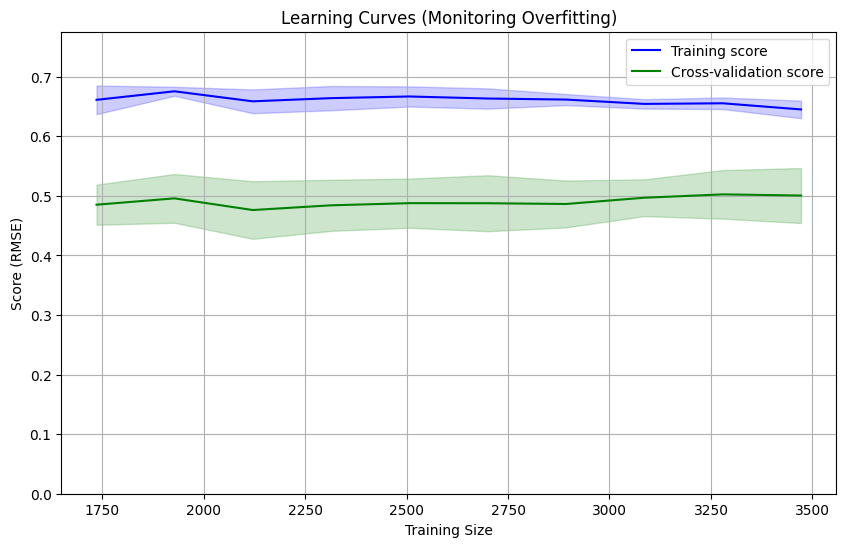

In [552]:
# Monitoring overfitting with Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    dt_regressor, X2_train_scaled, y2_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.5, 1, 10)
)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title("Learning Curves (Monitoring Overfitting)")
plt.xlabel("Training Size")
plt.ylabel("Score (RMSE)")
plt.ylim(0, max(train_mean.max(), test_mean.max()) + 0.1)  # Ensure the y-axis starts from 0
plt.legend(loc="best")
plt.grid(True)
plt.show()


---
Comment: 
- Mild Overfitting: The Decision Tree does show some signs of overfitting due to the gap, but since the test RMSE is low, it is not significant enough to be a concern.
- Good Generalization: The model performs well on unseen data, which is a key indicator that the model is not overfitting excessively.

##  D6
Consider the models we developed in D3, D4, D5
### 1. Discuss their respective RMSE on the test set, and which is the best model? Why?

---
Lasso Regression model:
RMSE on the training set: 0.45875229393258077
RMSE on the test set: 0.4559536591916135

Ridge Regression model: 
RMSE on the training set: 0.45877783276661427
RMSE on the test set: 0.45590719192269763

Decision Tree Regression model:
RMSE on the training set: 0.3933940522443819
RMSE on the test set: 0.45209398842740783

Best Predictive Performance: The Decision Tree model edges out Lasso and Ridge with a slightly lower test RMSE, indicating better predictive accuracy.

Regularization Benefits: Lasso and Ridge offer more robust generalization and are less prone to overfitting, particularly useful in datasets with potential multicollinearity or a large number of features.

Model Choice:
If interpretability and feature selection are priorities, Lasso may be preferred.
For managing multicollinearity with minimal overfitting, Ridge is a solid choice.
For best raw predictive performance on this dataset, the Decision Tree is currently the most effective.

Choosing the best model ultimately depends on the balance between predictive accuracy, interpretability, and the need for feature selection or regularization. We will chose Decision Tree model 

## D7 

Repeat the same process as in D5, but now use a Random Forest Regressor. Ensure that the random generator’s state of the model is set to 5508 for the splitting function. Consider using data2_W and apply an 80%-20% split for the training and test datasets. Standardize the data appropriately. Train a Random Forest model using 10-fold cross-validation and Grid-SearchCV to fine-tune the regularization parameters. In the grid, consider tuning the n_estimators (number of trees) to values like 50, 100, and 200, and max_depth (maximum depth of the trees) in the range of 3 to 15, with a step size of 1. Do not forget to set the random state to 5508. After fitting the model, evaluate it using RMSE on both the training set and the test set, and output the optimal parameters found through grid search, along with the RMSE results.

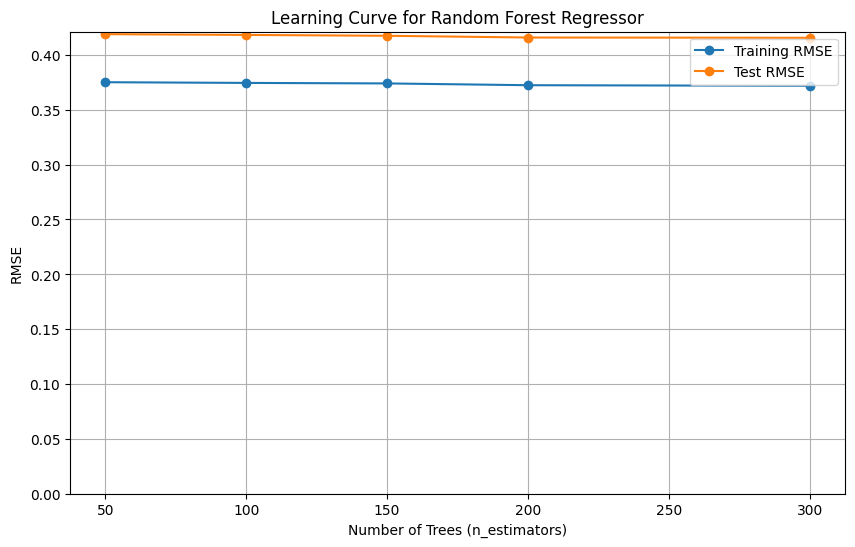

Optimal parameters: {'max_depth': 14, 'n_estimators': 200}
RMSE on the training set with final model: 0.37248535929689464
RMSE on the test set with final model: 0.4159940041687248


In [585]:
# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Define the Random Forest Regressor and the parameter grid
rf_regressor = RandomForestRegressor(random_state=5508)
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': range(3, 15, 1)     # Maximum depth of each tree
}

# Set up GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=cv)
grid_search.fit(X2_train_scaled, y2_train)

# Get the best model and optimal max_depth parameters
best_rf = grid_search.best_estimator_
optimal_max_depth = grid_search.best_params_['max_depth']

# Plot the learning curve by varying n_estimators while keeping the optimal max_depth
n_trees = [50, 100, 150, 200, 300]
train_rmse = []
test_rmse = []

for n in n_trees:
    # Initialize the Random Forest Regressor with the best max_depth
    rf_model = RandomForestRegressor(n_estimators=n, max_depth=optimal_max_depth, random_state=5508)
    
    # Fit the model to the training data
    rf_model.fit(X2_train_scaled, y2_train)
    
    # Make predictions on the train and test sets
    train_predictions = rf_model.predict(X2_train_scaled)
    test_predictions = rf_model.predict(X2_test_scaled)
    
    # Calculate RMSE for both train and test sets
    train_rmse.append(np.sqrt(mean_squared_error(y2_train, train_predictions)))
    test_rmse.append(np.sqrt(mean_squared_error(y2_test, test_predictions)))

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(n_trees, train_rmse, label='Training RMSE', marker='o')
plt.plot(n_trees, test_rmse, label='Test RMSE', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.ylim(bottom=0)  # Ensure the y-axis starts from 0
plt.title('Learning Curve for Random Forest Regressor')
plt.legend()
plt.grid(True)
plt.show()

# RMSE for the final model
train_predictions_final = best_rf.predict(X2_train_scaled)
test_predictions_final = best_rf.predict(X2_test_scaled)
train_rmse_final = np.sqrt(mean_squared_error(y2_train, train_predictions_final))
test_rmse_final = np.sqrt(mean_squared_error(y2_test, test_predictions_final))

print(f"Optimal parameters: {grid_search.best_params_}")
print(f"RMSE on the training set with final model: {train_rmse_final}")
print(f"RMSE on the test set with final model: {test_rmse_final}")


---
Interpretation:
- Good Generalization: The gap between training and test RMSE is relatively small. This suggests that the model is not overfitting, and it is generalizing well.

- Consistent Improvement: Both train and test RMSE values seem to stabilize, which suggests that further training or increasing model complexity might not significantly improve performance.

## D8

Repeat the same process as in D3 and D4, but now use Gradient Boosting Machine (GBM) for regression. Ensure to set the random generator's state to "5508" for reproducibility in splitting the data. Consider data2_W, using the 80%-20% splitting of the data into training and test sets, and ensure appropriate standardization (scaling the features). Perform 10-fold cross-validation to assess the model's performance more reliably. Use GridSearchCV to fine-tune the regularization parameters, particularly the number of estimators (n_estimators) and learning rate. Consider a range such as [50, 100, 200] to test how the number of trees in the ensemble affects the model's performance (n_estimators). Consider values like [0.01, 0.05, 0.1] (learning_rate). A lower learning rate may require a larger number of estimators. Test the max_depth parameter of the individual decision trees within the ensemble, with a range such as [3, 15,1]. Test subsample = [0.8, 1.0] to use a fraction of the training set for each boosting iteration.


Optimal parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
RMSE on the training set: 0.30596070189559244
RMSE on the test set: 0.3493806978729477


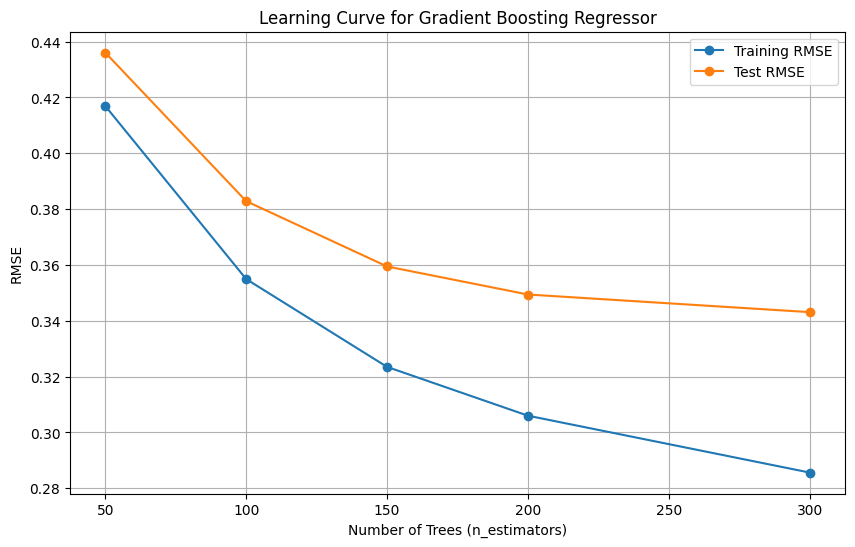

In [31]:
# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Define the Gradient Boosting Regressor and the parameter grid
gb_regressor = GradientBoostingRegressor(random_state=5508)

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages (trees)
    'max_depth': range(3, 15, 1),     # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinking
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting each tree
}

# Set up GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=cv)
grid_search.fit(X2_train_scaled, y2_train)

# Get the best model
best_gb = grid_search.best_estimator_

# Predictions
train_predictions = best_gb.predict(X2_train_scaled)
test_predictions = best_gb.predict(X2_test_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Output the results
print(f"Optimal parameters: {grid_search.best_params_}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")

# Optionally plot the learning curve 
# Define the range of n_estimators
n_trees = [50, 100, 150, 200, 300]

train_rmse_gb = []
test_rmse_gb = []

# Loop through the different n_estimators
for n in n_trees:
    # Initialize the model with the best parameters
    gb_model = GradientBoostingRegressor(
        n_estimators=n, 
        random_state=5508,
        max_depth=grid_search.best_params_['max_depth'],
        learning_rate=grid_search.best_params_['learning_rate'],
        subsample=grid_search.best_params_['subsample']
    )
    
    # Fit the model to the training data
    gb_model.fit(X2_train_scaled, y2_train)
    
    # Make predictions on the train and test sets
    train_predictions_gb = gb_model.predict(X2_train_scaled)
    test_predictions_gb = gb_model.predict(X2_test_scaled)
    
    # Calculate RMSE for both train and test sets
    train_rmse_gb.append(np.sqrt(mean_squared_error(y2_train, train_predictions_gb)))
    test_rmse_gb.append(np.sqrt(mean_squared_error(y2_test, test_predictions_gb)))

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(n_trees, train_rmse_gb, label='Training RMSE', marker='o')
plt.plot(n_trees, test_rmse_gb, label='Test RMSE', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Learning Curve for Gradient Boosting Regressor')
plt.legend()
plt.grid(True)
plt.show()


In [771]:
filtered_weekly_sales

,name,size,week_of_year,total_quantity_sold_W,price,is_holiday_week,season,price_category
0,The Barbecue Chicken Pizza,L,1,18,20.75,1,Winter,Medium
1,The Barbecue Chicken Pizza,L,2,13,20.75,1,Winter,Medium
2,The Barbecue Chicken Pizza,L,3,25,20.75,1,Winter,Medium
3,The Barbecue Chicken Pizza,L,4,15,20.75,1,Winter,Medium
4,The Barbecue Chicken Pizza,L,5,29,20.75,1,Winter,Medium
...,...,...,...,...,...,...,...,...
4818,The Vegetables + Vegetables Pizza,S,49,12,12.00,0,Fall,Low
4819,The Vegetables + Vegetables Pizza,S,50,9,12.00,0,Fall,Low
4820,The Vegetables + Vegetables Pizza,S,51,6,12.00,0,Fall,Low
4821,The Vegetables + Vegetables Pizza,S,52,6,12.00,0,Fall,Low


In [770]:
train_predictions_gb

array([2.24441294, 3.15377949, 2.60079155, ..., 2.9000002 , 2.40022927,
       3.08827622], shape=(3858,))

---
learning_rate: 0.1
max_depth: 4
n_estimators: 200
subsample: 0.8

learning_rate: The rate at which the model updates during training. A value of 0.1 suggests moderate learning, which is a common choice for gradient boosting models.

max_depth: The maximum depth of the individual decision trees. A depth of 4 means the trees are relatively shallow, which can help avoid overfitting.

n_estimators: The number of boosting stages or trees in the ensemble. 200 trees is a reasonable number for most problems, balancing performance and computational cost.

subsample: The fraction of training data used for fitting each tree. A value of 0.8 indicates that each tree is trained on 80% of the data, which is useful to prevent overfitting.

Training RMSE: 0.30596
Test RMSE: 0.34938

Understanding RMSE:
RMSE on the training set (0.30596) is lower than the RMSE on the test set (0.34938), which is typical. The model performs slightly better on the data it was trained on.
RMSE on the test set (0.34938) tells us how well the model generalizes to new, unseen data. Lower RMSE values indicate better performance.

Training vs. Test RMSE: The difference between the RMSE on the training and test sets (0.30596 vs. 0.34938) is relatively small, which indicates the model is not overfitting or underfitting significantly.
Magnitude of RMSE: RMSE values should be compared to the scale of our target variable. If the target values have a large range, an RMSE of 0.35 may be acceptable. If the values are small, it could indicate poor performance.

For example, if your target variable (quantity sold) ranges from 0 to 10, an RMSE of 0.35 could be considered reasonable, but if the target ranges from 0 to 1000, the error is relatively high.


=> Given that our target variable ranges from 0 to 45, an RMSE of about 0.31 indicates that the model is doing quite well on the training data. Similarly for test data, an RMSE of 0.35 is still relatively small compared to the target range (0-45), indicating that the model is performing well on the unseen data.

## D9 

Repeat the same process as in D3 and D4, but now use Support Vector Regression (SVR). Set the random generator’s state of the class to the value “5508” for reproducibility in cross-validation and grid search. Consider the dataset data2_W, using the 80%-20% split of the data for training and testing, and make sure to apply the appropriate standardisation of the features. Train the SVM model using 10-fold cross-validation and GridSearchCV to fine-tune the regularisation parameters C, epsilon, and kernel.
In our grid search, consider the following hyperparameters:
C: [0.1, 1, 10] — Regularization parameter (controls the trade-off between fitting the model and maintaining generalization).
epsilon: [0.01, 0.1, 0.2] — Defines the margin of tolerance for errors.
kernel: ['linear', 'poly', 'rbf'] — The type of kernel to use (linear, polynomial, or radial basis function).

Optimal parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
RMSE on the training set: 0.46177231247032224
RMSE on the test set: 0.4604164546580095


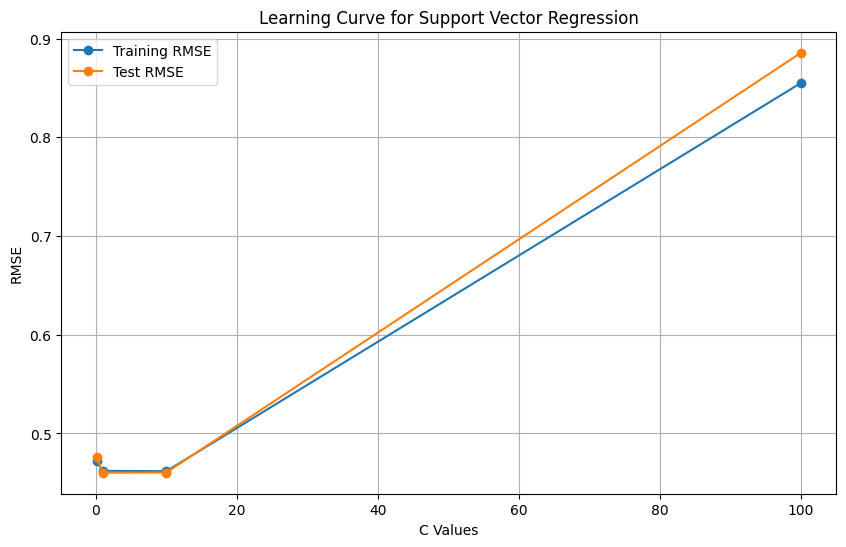

In [587]:
# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Define the Support Vector Regressor and the parameter grid
svm_regressor = SVR()

param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2], # Epsilon parameter (defines the margin of error)
    'kernel': ['linear', 'poly', 'rbf']  # Type of kernel to use
}

# Set up GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=cv)
grid_search.fit(X2_train_scaled, y2_train)

# Get the best model
best_svm = grid_search.best_estimator_

# Predictions
train_predictions = best_svm.predict(X2_train_scaled)
test_predictions = best_svm.predict(X2_test_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Output the results
print(f"Optimal parameters: {grid_search.best_params_}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")

# Optionally, plot the learning curve
# Define the range of C values
C_values = [0.1, 1, 10, 100]

train_rmse_svr = []
test_rmse_svr = []

# Loop through the different C values
for c in C_values:
    # Initialize the model with the best parameters found earlier
    svm_model = SVR(
        C=c, 
        epsilon=grid_search.best_params_['epsilon'],
        kernel=grid_search.best_params_['kernel']
    )
    
    # Fit the model to the training data
    svm_model.fit(X2_train_scaled, y2_train)
    
    # Make predictions on the train and test sets
    train_predictions_svr = svm_model.predict(X2_train_scaled)
    test_predictions_svr = svm_model.predict(X2_test_scaled)
    
    # Calculate RMSE for both train and test sets
    train_rmse_svr.append(np.sqrt(mean_squared_error(y2_train, train_predictions_svr)))
    test_rmse_svr.append(np.sqrt(mean_squared_error(y2_test, test_predictions_svr)))

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(C_values, train_rmse_svr, label='Training RMSE', marker='o')
plt.plot(C_values, test_rmse_svr, label='Test RMSE', marker='o')
plt.xlabel('C Values')
plt.ylabel('RMSE')
plt.title('Learning Curve for Support Vector Regression')
plt.legend()
plt.grid(True)
plt.show()


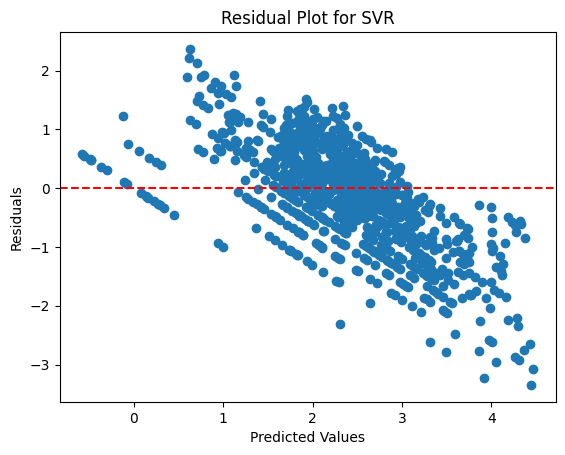

In [589]:
residuals = y2_test - test_predictions_svr
plt.scatter(test_predictions_svr, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for SVR")
plt.show()

---
Interpretation of a Downward Trend:
Model Underfitting: If the residuals are systematically increasing or decreasing with the predicted values, it can indicate that the model is underfitting, meaning it is not capturing the underlying pattern in the data adequately. In this case, the model might not be complex enough (which means the linear kernel in SVR may be too simple for the data).

=> Try a Non-Linear Model: If you're using a linear kernel, try switching to a non-linear kernel like RBF (Radial Basis Function), as it may better capture the complex patterns in the data.

Optimal parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
RMSE on the training set: 0.5015918237191924
RMSE on the test set: 0.5307724523954416


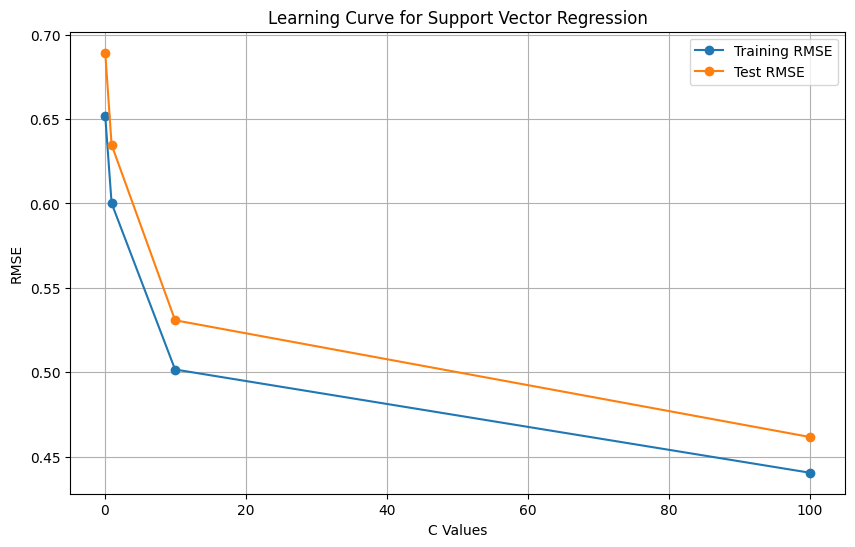

In [590]:
# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Define the Support Vector Regressor and the parameter grid
svm_regressor = SVR()

param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2], # Epsilon parameter (defines the margin of error)
    'kernel': ['poly', 'rbf']  # Type of kernel to use
}

# Set up GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=cv)
grid_search.fit(X2_train_scaled, y2_train)

# Get the best model
best_svm = grid_search.best_estimator_

# Predictions
train_predictions = best_svm.predict(X2_train_scaled)
test_predictions = best_svm.predict(X2_test_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y2_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_test, test_predictions))

# Output the results
print(f"Optimal parameters: {grid_search.best_params_}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")

# Optionally, plot the learning curve
# Define the range of C values
C_values = [0.1, 1, 10, 100]

train_rmse_svr = []
test_rmse_svr = []

# Loop through the different C values
for c in C_values:
    # Initialize the model with the best parameters found earlier
    svm_model = SVR(
        C=c, 
        epsilon=grid_search.best_params_['epsilon'],
        kernel=grid_search.best_params_['kernel']
    )
    
    # Fit the model to the training data
    svm_model.fit(X2_train_scaled, y2_train)
    
    # Make predictions on the train and test sets
    train_predictions_svr = svm_model.predict(X2_train_scaled)
    test_predictions_svr = svm_model.predict(X2_test_scaled)
    
    # Calculate RMSE for both train and test sets
    train_rmse_svr.append(np.sqrt(mean_squared_error(y2_train, train_predictions_svr)))
    test_rmse_svr.append(np.sqrt(mean_squared_error(y2_test, test_predictions_svr)))

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(C_values, train_rmse_svr, label='Training RMSE', marker='o')
plt.plot(C_values, test_rmse_svr, label='Test RMSE', marker='o')
plt.xlabel('C Values')
plt.ylabel('RMSE')
plt.title('Learning Curve for Support Vector Regression')
plt.legend()
plt.grid(True)
plt.show()


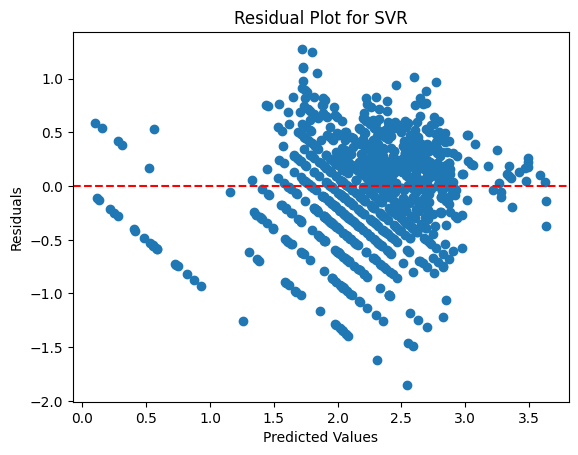

In [591]:
residuals = y2_test - test_predictions_svr
plt.scatter(test_predictions_svr, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for SVR")
plt.show()


--- 
after remove linear in kernel:

Interpretation of Results
Optimal Parameters:

C = 10: This is the regularization parameter. A higher value of C indicates less regularization, meaning the model will aim to fit the training data more closely (which can lead to overfitting if too high). c= 10 in here is a good parameter. 
epsilon = 0.1: Defines the margin of tolerance where no penalty is given for errors. Smaller values mean the model tries to fit the training data more precisely. epsilon = 0.1 is good in this case
kernel = 'rbf' (Radial Basis Function): used to transform the input data to a higher-dimensional space where a linear model is applied.

RMSE (Root Mean Squared Error) Values:

Training RMSE: 0.5016
Test RMSE: 0.5308
The fact that the training RMSE is slightly lower than the test RMSE is typical because the model performs better on the data it was trained on. However, the gap is relatively small, which is a good sign because it suggests that the model is generalizing reasonably well to new (test) data.

## D10

Consider data2_W, and use only the category features. Using the 80%-20% splitting of the data,
apply MCA in the training set with encoded features. Pay attention if you need to set
the random state of your MCA procedure.

Number of components that explain 90.0% of the variance: 31


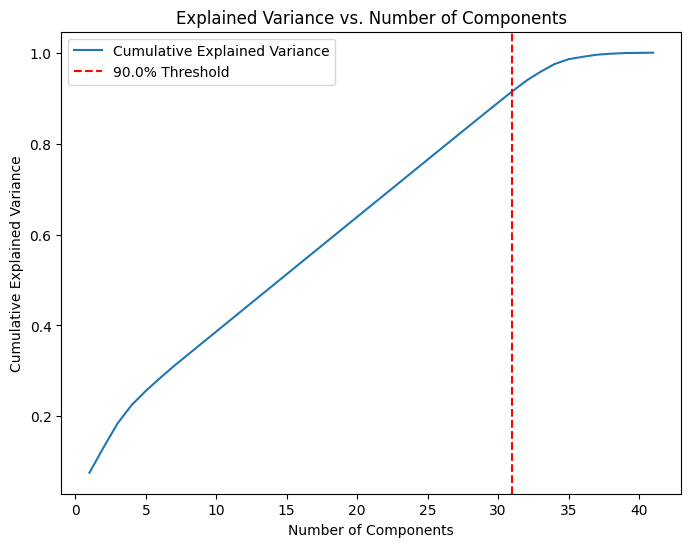

In [592]:
# Define the columns to drop
numerical_columns_d8 = ['total_quantity_sold_W', 'price', 'week_of_year']

# Drop the specified columns from the DataFrame
data2_W_d8 = data2_W.drop(columns=numerical_columns_d8)

# Separate the features and the target variable
X2_d8 = data2_W_d8
y2_d8 = data2_W['total_quantity_sold_W']

# The category features are already encoded
# Split the data into train and test sets (80%-20% split)
X2_d8_train, X2_d8_test, y2_d8_train, y2_d8_test = train_test_split(X2_d8, y2_d8, test_size=0.2, random_state=5508)

# Apply Multiple Correspondence Analysis (MCA)
mca = prince.MCA(n_components=data2_W_d8.shape[1], random_state=5508)  # Set n_components as needed
mca.fit(X2_d8_train)

# Step: Calculate the eigenvalues (this reflects the amount of variance explained by each component)
eigenvalues = mca.eigenvalues_

# Step: Calculate explained variance ratio
explained_variance_ratio = eigenvalues / eigenvalues.sum()

# Step: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step : Choose the number of components to retain
# For example, choose the components that explain at least 90% of the variance
threshold = 0.90
n_components_selected = (cumulative_explained_variance >= threshold).argmax() + 1

# Print the number of components selected
print(f"Number of components that explain {threshold*100}% of the variance: {n_components_selected}")

# Step 5: Plot the explained variance and cumulative variance to visualize
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, label='Cumulative Explained Variance')
plt.axvline(x=n_components_selected, color='r', linestyle='--', label=f'{threshold*100}% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.show()



In [593]:
# Step: Fit MCA again using the selected number of components
# Transform the data using the selected number of principal components
mca_selected = prince.MCA(n_components=n_components_selected, random_state=5508)
X2_d8_train_mca = mca_selected.fit_transform(X2_d8_train)
X2_d8_test_mca = mca_selected.transform(X2_d8_test)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X2_d8_train_mca, y2_d8_train)

# Make predictions
train_mca_predictions = lr_model.predict(X2_d8_train_mca)
test_mca_predictions = lr_model.predict(X2_d8_test_mca)

# Calculate RMSE
train_mca_rmse = np.sqrt(mean_squared_error(y2_d8_train, train_mca_predictions))
test_mca_rmse = np.sqrt(mean_squared_error(y2_d8_test, test_mca_predictions))

# Print RMSE
print(f"RMSE on the training set: {train_mca_rmse}")
print(f"RMSE on the test set: {test_mca_rmse}")


RMSE on the training set: 0.5172204623858112
RMSE on the test set: 0.5340533598907272


In [594]:
# Define the pipeline
pipeline = Pipeline([
    ('mca', prince.MCA()),
    ('lr', LinearRegression())
])

# Set up 10-fold cross-validation with a fixed random state
cv = KFold(n_splits=10, shuffle=True, random_state=5508)

# Set up parameter grid for MCA number of components
param_grid = {
    'mca__n_components': range(1, X2_d8_train.shape[1] + 1)
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)

# Fit GridSearchCV to the training data
grid_search.fit(X2_d8_train, y2_d8_train)

# Get the optimal number of components
optimal_components = grid_search.best_params_['mca__n_components']

# Get best estimator
best_model = grid_search.best_estimator_

# Make predictions
train_predictions = best_model.predict(X2_d8_train)
test_predictions = best_model.predict(X2_d8_train)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y2_d8_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y2_d8_train, test_predictions))

# Print results
print(f"Optimal number of principal components: {optimal_components}")
print(f"RMSE on the training set: {train_rmse}")
print(f"RMSE on the test set: {test_rmse}")


Optimal number of principal components: 41
RMSE on the training set: 0.461410558734036
RMSE on the test set: 0.461410558734036


---
To compare the models and choose the best one, we need to focus on the RMSE (Root Mean Squared Error) values for both the training and test sets. Lower RMSE indicates a better model fit.

Here's a comparison of the models:

1. Lasso Model
RMSE on the training set: 0.45875229393258077
RMSE on the test set: 0.4559536591916135

2. Ridge Model
RMSE on the training set: 0.45877783276661427
RMSE on the test set: 0.45590719192269763

3. Decision Tree Regression
RMSE on the training set: 0.3933940522443819
RMSE on the test set: 0.45209398842740783

4. Random forest model
RMSE on the training set with final model: 0.37248535929689464
RMSE on the test set with final model: 0.4159940041687248

5. GBM - Gradient Boosting Machine model
RMSE on the training set: 0.30596070189559244
RMSE on the test set: 0.3493806978729477 

6. SVR - Support Vector Regression model
RMSE on the training set: 0.5015918237191924
RMSE on the test set: 0.5307724523954416

7. MCA Model with GridSearchCV
Optimal number of principal components: 41
RMSE on the training set: 0.461410558734036
RMSE on the test set: 0.461410558734036

Conclusion:
The Gradient Boosting Machine (GBM) is the best model based on the lowest RMSE on both the training and test sets. It indicates a good balance between fitting the training data and generalizing to new, unseen data.

# Use Gradient Boosting model to predict

In [ ]:
# prepare dataset to predict for the whole year 2016

In [32]:
# Load the data
df = pd.read_excel('data_pizza.xlsx')

# Create a copy of the original DataFrame
df_copy = df.copy()

# Remove the specified columns
df_copy = df_copy.drop(columns=['date', 'time', 'pizza_id', 'quantity', 'order_id', 'category', 'ingredients'])

# Remove duplicate rows based on 'name' and 'size' columns
df_copy = df_copy.drop_duplicates(subset=['name', 'size'])

# Categorizing the price into ranges (e.g., Low, Medium, High) might help the model understand how the price range impacts sales.
def price_category(price):
    if price < 15:
        return 'Low'
    elif 15 <= price < 25:
        return 'Medium'
    else:
        return 'High'

# Apply to the weekly and monthly datasets
df_copy['price_category'] = df_copy['price'].apply(price_category)

# Display the modified DataFrame
print(df_copy.head())
df_copy

     size  price                          name price_category
0       L  20.75        The Thai Chicken Pizza         Medium
1321    L  20.75   The Southwest Chicken Pizza         Medium
2291    L  20.75    The Barbecue Chicken Pizza         Medium
3234    L  20.75  The California Chicken Pizza         Medium
4099    L  20.75       The Chicken Pesto Pizza         Medium


,size,price,name,price_category
0,L,20.75,The Thai Chicken Pizza,Medium
1321,L,20.75,The Southwest Chicken Pizza,Medium
2291,L,20.75,The Barbecue Chicken Pizza,Medium
3234,L,20.75,The California Chicken Pizza,Medium
4099,L,20.75,The Chicken Pesto Pizza,Medium
...,...,...,...,...
44709,S,12.25,The Sicilian Pizza,Low
45420,S,9.75,The Pepperoni Pizza,Low
46147,S,10.50,The Hawaiian Pizza,Low
47129,XL,25.50,The Greek Pizza,High


In [33]:
# Generate dates for the whole year of 2016
start_date = '2016-01-01'
end_date = '2016-12-31'

# Create a date range for all dates in this period
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Group the dates by week and get the week number
week_numbers = date_range.isocalendar().week

# Create a new DataFrame with 'date' and 'week' columns
date_df = pd.DataFrame({'date': date_range, 'week_of_year': week_numbers})

# Get US holidays for the year 2016 (adjust to the correct year)
us_holidays = holidays.US(years=2016, state='NJ')

# Define additional custom holidays for 2016
custom_holidays = {
    'St. Patrick’s Day': '2016-03-17',
    'Cesar Chavez Day': '2016-03-31',
    'Yom Kippur Start': '2016-09-12',  # Example date for 2016
    'Yom Kippur End': '2016-09-13',
    'Christmas Day': '2016-12-25',
    'Valentine’s Day': '2016-02-14',
    'Halloween': '2016-10-31',
    'New Year’s Eve': '2016-12-31',
    'Black Friday': '2016-11-25',
    'Easter Sunday': '2016-03-27'
}

# Convert custom holidays to a datetime list
custom_holiday_dates = pd.to_datetime(list(custom_holidays.values()))

# Combine the default US holidays and custom holidays, ensuring all are in the same format
all_holidays = pd.to_datetime(list(us_holidays.keys())).union(custom_holiday_dates)

# Add a new column to mark holidays in the 'date_df' dataset
date_df['is_holiday_week'] = date_df['date'].isin(all_holidays).astype(int)

# Define a function to determine the season based on the month and day
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.month >= 1):
        return 'Winter'
    elif (date.month == 3 and date.day >= 20) or (date.month <= 6 and date.month >= 4):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month <= 9 and date.month >= 7):
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the 'date' column
date_df['season'] = date_df['date'].apply(get_season)

# Group by week to get the maximum 'is_holiday_week' value for each week and the first season occurrence
weekly_holiday_df = date_df.groupby('week_of_year', as_index=False).agg({'is_holiday_week': 'max', 'season': 'first'})

# Display the updated DataFrame
print(weekly_holiday_df)


    week_of_year  is_holiday_week  season
0              1                0  Winter
1              2                0  Winter
2              3                1  Winter
3              4                0  Winter
4              5                0  Winter
5              6                1  Winter
6              7                1  Winter
7              8                0  Winter
8              9                0  Winter
9             10                0  Winter
10            11                1  Winter
11            12                1  Winter
12            13                1  Winter
13            14                0  Spring
14            15                0  Spring
15            16                0  Spring
16            17                0  Spring
17            18                0  Spring
18            19                0  Spring
19            20                0  Spring
20            21                0  Spring
21            22                1  Spring
22            23                0 

In [34]:
# Ensure 'weekly_holiday_df' has 12 rows and 'df_copy' has 91 rows
print(weekly_holiday_df.shape)
print(df_copy.shape)

# Create a common key column in both dataframes (e.g., an index column)
weekly_holiday_df['key'] = 1
df_copy['key'] = 1

# Merge the two dataframes on the 'key' column (cartesian product)
merged_df = pd.merge(weekly_holiday_df, df_copy, on='key').drop('key', axis=1)

# Display the merged dataset
print(merged_df.head(20))
print(merged_df.shape)  # It should have 12 * 91 rows


(53, 3)
(91, 4)
    week_of_year  is_holiday_week  season size  price  \
0              1                0  Winter    L  20.75   
1              1                0  Winter    L  20.75   
2              1                0  Winter    L  20.75   
3              1                0  Winter    L  20.75   
4              1                0  Winter    L  20.75   
5              1                0  Winter    L  20.75   
6              1                0  Winter    L  20.75   
7              1                0  Winter    L  20.75   
8              1                0  Winter    L  20.75   
9              1                0  Winter    L  20.75   
10             1                0  Winter    L  20.75   
11             1                0  Winter    L  20.75   
12             1                0  Winter    L  20.75   
13             1                0  Winter    L  20.25   
14             1                0  Winter    L  20.25   
15             1                0  Winter    L  20.25   
16             

In [35]:
# Perform one-hot encoding without dropping any category

# name variale
name_dummies = pd.get_dummies(merged_df['name'], prefix='name', drop_first=False)
# Manually drop the 'The Barbecue Chicken Pizza' dummy variable
name_dummies.drop('name_The Barbecue Chicken Pizza', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
name_dummies = name_dummies.astype(int)

# size variable
size_dummies = pd.get_dummies(merged_df['size'], prefix='size', drop_first=False)
# Manually drop the 'L' dummy variable
size_dummies.drop('size_L', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
size_dummies = size_dummies.astype(int)

# season variable
season_dummies = pd.get_dummies(merged_df['season'], prefix='season', drop_first=False)
# Manually drop the 'Fall' dummy variable
season_dummies.drop('season_Fall', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
season_dummies = season_dummies.astype(int)

# price_category variable
price_cate_dummies = pd.get_dummies(merged_df['price_category'], prefix='price_category', drop_first=False)
# Manually drop the 'High' dummy variable
price_cate_dummies.drop('price_category_High', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
price_cate_dummies = price_cate_dummies.astype(int)

# is_holiday variable
holiday_dummies = pd.get_dummies(merged_df['is_holiday_week'], prefix='is_holiday_week', drop_first=False)
# Manually drop the '0' dummy variable
holiday_dummies.drop('is_holiday_week_0', axis=1, inplace=True)
# Ensure dummy variables are numerical (0-FALSE and 1-TRUE)
holiday_dummies = holiday_dummies.astype(int)

# ----------
# Concatenate the dummy variables with the original DataFrame
data_predict = pd.concat([merged_df, name_dummies], axis=1)
data_predict = pd.concat([data_predict, size_dummies], axis=1)
data_predict = pd.concat([data_predict, season_dummies], axis=1)
data_predict = pd.concat([data_predict, price_cate_dummies], axis=1)
data_predict = pd.concat([data_predict, holiday_dummies], axis=1)

# Drop the original categorical columns
data_predict.drop(['name', 'size', 'season', 'price_category', 'is_holiday_week'], axis=1, inplace=True)

# Now 'data_predict' contains the original features along with the one-hot encoded features


In [36]:
# scale data 
class ScaleNumericExceptOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_prefixes):
        self.one_hot_prefixes = one_hot_prefixes
        self.scaler = StandardScaler()
        self.cols_to_scale = None

    def fit(self, X):
        # Identify numeric columns
        numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
        
        # Identify one-hot encoded columns based on provided prefixes
        one_hot_cols = [col for col in X.columns if any(col.startswith(prefix) for prefix in self.one_hot_prefixes)]
        
        # Columns to scale are numeric columns excluding the one-hot encoded columns
        self.cols_to_scale = [col for col in numeric_cols if col not in one_hot_cols]
        
        # Fit the scaler on the columns to scale
        self.scaler.fit(X[self.cols_to_scale])
        return self

    def transform(self, X):
        # Transform the columns to scale
        X_copy = X.copy()
        X_copy[self.cols_to_scale] = self.scaler.transform(X_copy[self.cols_to_scale])
        return X_copy

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# Define the prefixes or patterns that identify the one-hot encoded columns
one_hot_prefixes = ['name_', 'size_', 'season_', 'price_category_', 'is_holiday_']

# Initialize the transformer with the one-hot prefixes
scale_numeric_data = ScaleNumericExceptOneHot(one_hot_prefixes=one_hot_prefixes)

# Usage:
# Assuming X1_train and X1_test are your training and test data DataFrames
data_predict_scale = scale_numeric_data.fit_transform(data_predict)


In [37]:
data_predict_scale

,week_of_year,price,name_The Big Meat Pizza,name_The Brie Carre Pizza,name_The Calabrese Pizza,name_The California Chicken Pizza,name_The Chicken Alfredo Pizza,name_The Chicken Pesto Pizza,name_The Classic Deluxe Pizza,name_The Five Cheese Pizza,...,size_M,size_S,size_XL,size_XXL,season_Spring,season_Summer,season_Winter,price_category_Low,price_category_Medium,is_holiday_week_1
0,1,1.033697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,1.033697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,1.033697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,1.033697,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,1.033697,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,53,-1.036641,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,1
4819,53,-1.645564,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,1
4820,53,-1.462887,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,1
4821,53,2.190650,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [38]:
# Predicting on the new dataset using the best Gradient Boosting model
predictions = best_gb.predict(data_predict_scale)

# Display the predictions
print("Predictions on the new dataset:")
print(predictions)

# If we have the true target values for evaluation (optional)
# true_values = ...  # Provide the true values if available
# rmse_new_data = np.sqrt(mean_squared_error(true_values, predictions))
# print(f"RMSE on the new dataset: {rmse_new_data}")

Predictions on the new dataset:
[ 3.02196472  2.42709227  2.62335316 ...  2.26929074  1.13787644
 -0.54839754]


In [39]:
# way to reverse log_transformed

import numpy as np
original_value = 100
log_transformed = np.log1p(original_value)  # log(1 + 100)
print(log_transformed)

# output: log_transformed = 4.615120516

reversed_value = np.expm1(log_transformed)  # exp(4.615120516) - 1
print(reversed_value)

# output: reversed_value = 100.0

4.61512051684126
100.00000000000003


In [40]:
# reverse target predictions
quantity_prediction_2016 = np.expm1(predictions)
quantity_prediction_2016

array([19.53159089, 10.32590152, 12.78185903, ...,  8.67253799,
        2.12013554, -0.42212491], shape=(4823,))

In [41]:
# Print the first 20 elements of the numpy array
print(quantity_prediction_2016[:100])

[19.53159089 10.32590152 12.78185903 17.04786947  7.52966628  2.6457872
  6.92758572  5.83768402  8.54743912 11.08350183 10.84034778 17.87515076
 18.76628776 11.07402853  8.92511254  7.35665045  8.51610012  4.99714541
  5.65500446  3.6235257   6.56307442  9.62596199 10.54365533 11.91277036
 11.93702511  3.75309134  4.26290585 11.3143232  14.14161834 23.38376705
 15.55156673  7.38803449  5.39737006  2.07921675  5.43809903  8.01857806
  4.42457235  5.57978716  5.09594085  6.28194039  7.14632852  8.89739651
 18.33048252  6.45858227  3.4345979   8.9343137   5.531041   14.41226411
 14.91173096  9.22561869  7.60285507  4.8829659   7.30012824  4.49640532
  4.11125803  4.99011657  6.36459692  7.82195223 12.5644659   7.95199384
  7.71712594  7.07720734  6.27374171  4.9393044   4.8401164   3.3727619
  2.60993551  2.89066269 21.3700085   3.79354835  1.17348019  3.26327258
  3.69033544  6.16143432  5.77595399  6.44990477  6.63039864  5.15267355
  6.76401472  5.02967896  3.47563582  3.15821343  3.9

In [42]:
import pandas as pd

# Convert the numpy array to a DataFrame
quantity_prediction_2016_df = pd.DataFrame(quantity_prediction_2016, columns=['predicted_quantity'])

# Now you can use DataFrame methods like head()
print(quantity_prediction_2016_df.head(20))


    predicted_quantity
0            19.531591
1            10.325902
2            12.781859
3            17.047869
4             7.529666
5             2.645787
6             6.927586
7             5.837684
8             8.547439
9            11.083502
10           10.840348
11           17.875151
12           18.766288
13           11.074029
14            8.925113
15            7.356650
16            8.516100
17            4.997145
18            5.655004
19            3.623526


In [43]:
# Assuming merged_df has a common column to join on, e.g., 'date'
# You can also specify how='inner', 'outer', 'left', or 'right' for the merge

merged_df_with_predictions = pd.concat([merged_df, quantity_prediction_2016_df], axis=1)

# Or, if you want to merge based on a specific column (for example, 'date')
# merged_df_with_predictions = pd.merge(merged_df, quantity_prediction_2016_df, left_on='date', right_index=True, how='left')

# Display the merged DataFrame
print(merged_df_with_predictions.head())


   week_of_year  is_holiday_week  season size  price  \
0             1                0  Winter    L  20.75   
1             1                0  Winter    L  20.75   
2             1                0  Winter    L  20.75   
3             1                0  Winter    L  20.75   
4             1                0  Winter    L  20.75   

                           name price_category  predicted_quantity  
0        The Thai Chicken Pizza         Medium           19.531591  
1   The Southwest Chicken Pizza         Medium           10.325902  
2    The Barbecue Chicken Pizza         Medium           12.781859  
3  The California Chicken Pizza         Medium           17.047869  
4       The Chicken Pesto Pizza         Medium            7.529666  


In [53]:
merged_df_with_predictions.dtypes

week_of_year           UInt32
is_holiday_week         int64
season                 object
size                   object
price                 float64
name                   object
price_category         object
predicted_quantity    float64
total_sales           float64
dtype: object

In [44]:
merged_df_with_predictions

,week_of_year,is_holiday_week,season,size,price,name,price_category,predicted_quantity
0,1,0,Winter,L,20.75,The Thai Chicken Pizza,Medium,19.531591
1,1,0,Winter,L,20.75,The Southwest Chicken Pizza,Medium,10.325902
2,1,0,Winter,L,20.75,The Barbecue Chicken Pizza,Medium,12.781859
3,1,0,Winter,L,20.75,The California Chicken Pizza,Medium,17.047869
4,1,0,Winter,L,20.75,The Chicken Pesto Pizza,Medium,7.529666
...,...,...,...,...,...,...,...,...
4818,53,1,Winter,S,12.25,The Sicilian Pizza,Low,6.001474
4819,53,1,Winter,S,9.75,The Pepperoni Pizza,Low,7.645581
4820,53,1,Winter,S,10.50,The Hawaiian Pizza,Low,8.672538
4821,53,1,Winter,XL,25.50,The Greek Pizza,High,2.120136


In [45]:
# Assuming 'quantity' and 'price' are columns in merged_df_with_predictions
merged_df_with_predictions['total_sales'] = merged_df_with_predictions['predicted_quantity'] * merged_df_with_predictions['price']

# Display the first few rows to verify the calculation
print(merged_df_with_predictions[['predicted_quantity', 'price', 'total_sales']].head())


   predicted_quantity  price  total_sales
0           19.531591  20.75   405.280511
1           10.325902  20.75   214.262457
2           12.781859  20.75   265.223575
3           17.047869  20.75   353.743291
4            7.529666  20.75   156.240575


In [46]:
# Sum up total sales
total_sales_sum = merged_df_with_predictions['total_sales'].sum()

# Sum up quantity
quantity_sum = merged_df_with_predictions['predicted_quantity'].sum()

# Print the results
print(f"Total Sales Sum: {total_sales_sum}")
print(f"Quantity Sum: {quantity_sum}")


Total Sales Sum: 766410.2264293174
Quantity Sum: 46456.417408155285


2015 total sales: 817.86K

2015 total quantity: 49574

2016 Total Sales: 766410.2264293174

2016 Quantity: 46456.417408155285

Seems like predicted quantity in 2016 according to the predicting model has lower sales and lower quantity than 2015. For further understanding, we can plot total sales, quantity by month, week with the predicted quantity to find out the reasons. 


                   feature  importance
1                    price    0.188759
0             week_of_year    0.102819
2  name_The Big Meat Pizza    0.055622


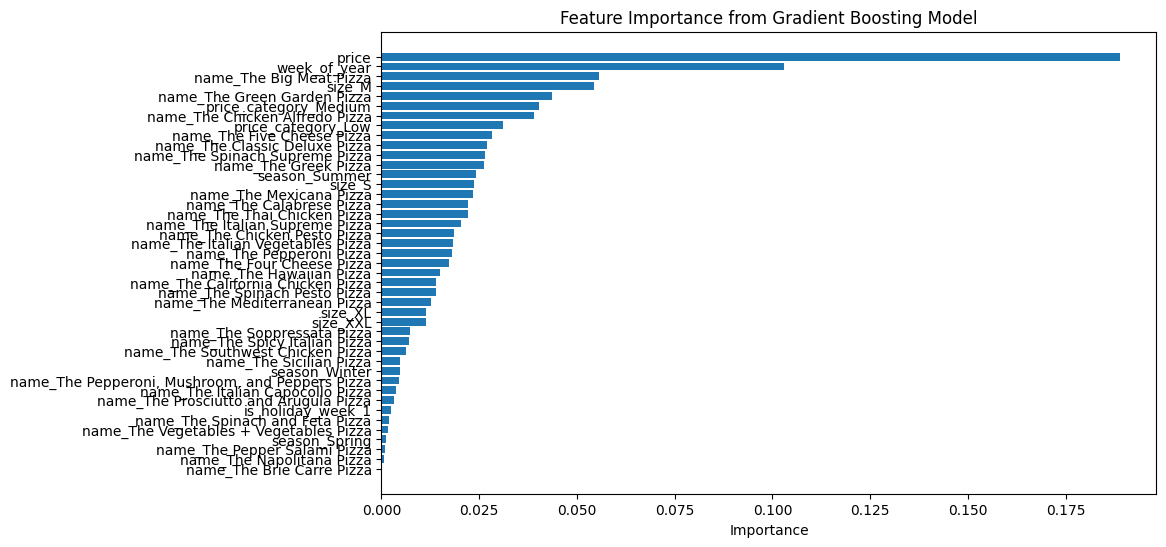

In [72]:
# Get the feature importances from the trained model (Gradient Boosting)
feature_importances = best_gb.feature_importances_

# Get the column names from the transformed data (after one-hot encoding)
features = data_predict.columns

# Create a DataFrame with feature names and their importance values
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display the top features with the highest importance
print(importance_df.head(3))

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Gradient Boosting Model')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\4285073661.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


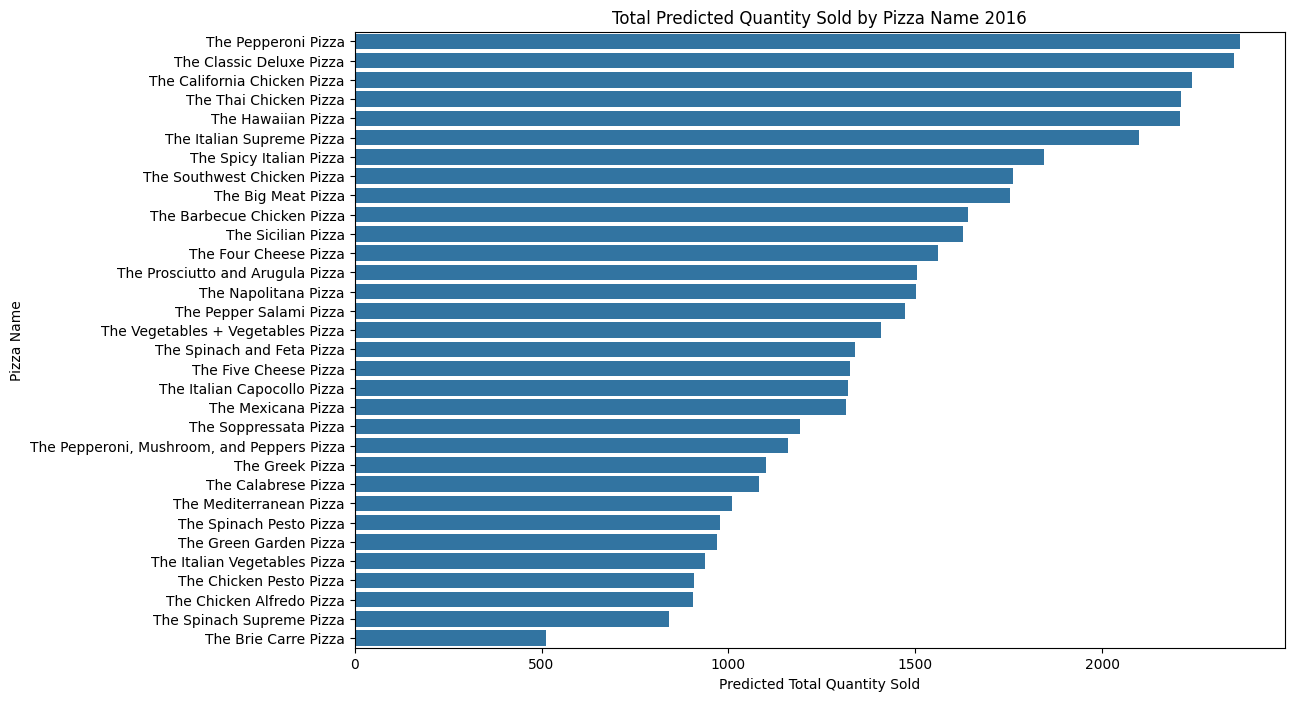

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'name' and sum 'predicted_quantity'
name_quantity_summary = merged_df_with_predictions.groupby('name')['predicted_quantity'].sum().sort_values(ascending=False)

# Plot for 'name' vs 'predicted_quantity_sold_W'
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed for better readability
sns.barplot(
    x='predicted_quantity', 
    y='name', 
    data=merged_df_with_predictions, 
    estimator=sum, 
    ci=None, 
    order=name_quantity_summary.index,  # Ordering by summed predicted quantity for each pizza name
    orient='h'  # Horizontal orientation
)

plt.title('Total Predicted Quantity Sold by Pizza Name 2016')
plt.xlabel('Predicted Total Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()


- top 6 pizza around 2000-2500 quantity sold: the pepperoni pizza > the classic deluxe pizza > the california chicken pizza > the thai chicken pizza > the hawaiian pizza > The Italian Supreme Pizza
- bottom pizza around 500 quantity sold: the bire carre pizza.
- other pizza around nearly 800-2000 quantity sold.

C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\551615470.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='size', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[0, 0])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\551615470.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='is_holiday_week', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[0, 1])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\551615470.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[1, 0])
C:\Users\pearr\AppData\Local\Temp\ipykernel_16916\551615470.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the sa

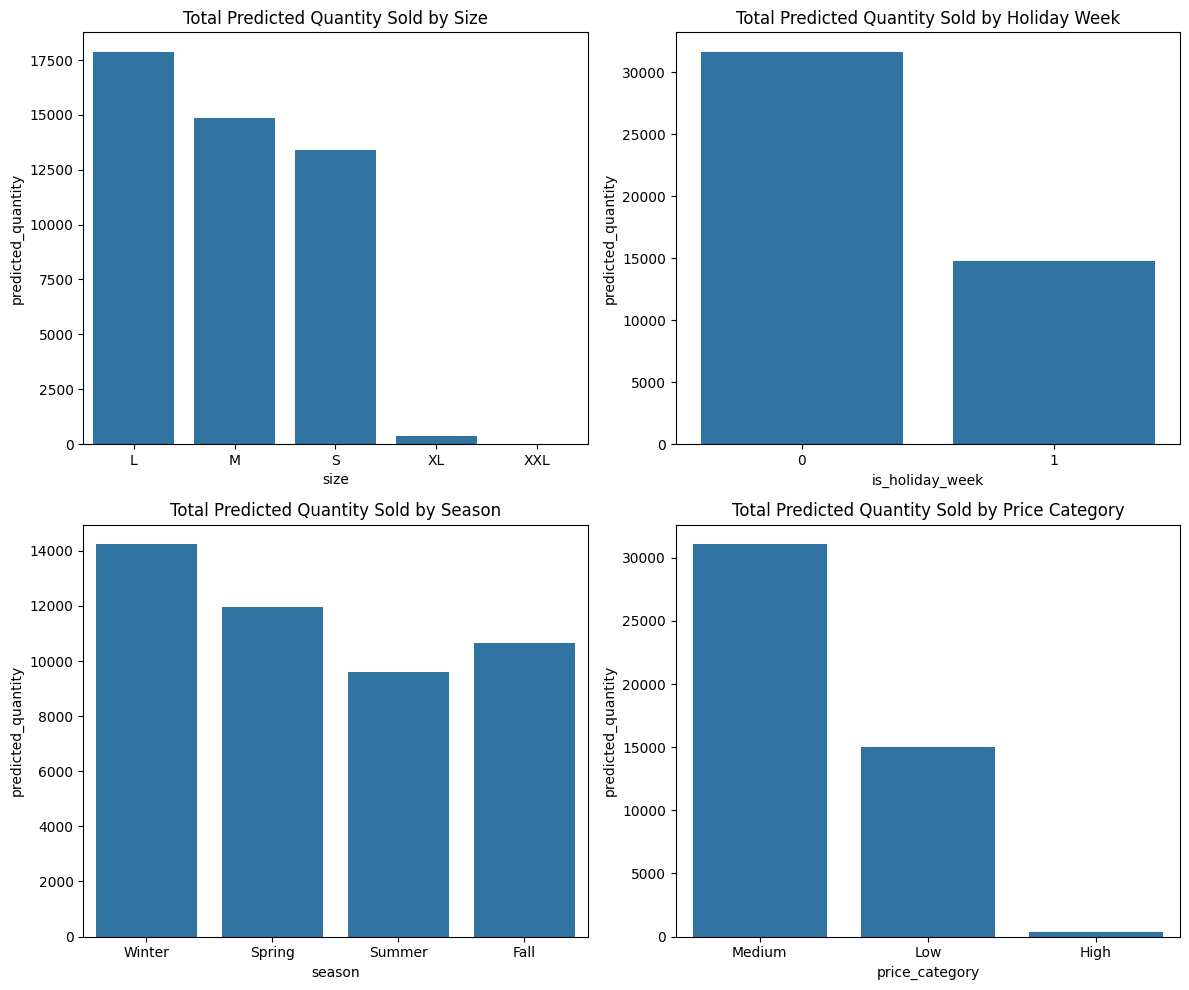

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed for better readability

# Plot for 'size' vs 'predicted_quantity'
sns.barplot(x='size', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[0, 0])
axes[0, 0].set_title('Total Predicted Quantity Sold by Size')

# Plot for 'is_holiday_week' vs 'predicted_quantity'
sns.barplot(x='is_holiday_week', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[0, 1])
axes[0, 1].set_title('Total Predicted Quantity Sold by Holiday Week')

# Plot for 'season' vs 'predicted_quantity'
sns.barplot(x='season', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[1, 0])
axes[1, 0].set_title('Total Predicted Quantity Sold by Season')

# Plot for 'price_category' vs 'predicted_quantity'
sns.barplot(x='price_category', y='predicted_quantity', data=merged_df_with_predictions, estimator=sum, ci=None, ax=axes[1, 1])
axes[1, 1].set_title('Total Predicted Quantity Sold by Price Category')

# Adjust layout to make sure everything fits well
plt.tight_layout()
plt.show()


- quantity sold by size: L>M>S>XL>XXL
- non-holiday sold more than holiday around 2.2 times
- Quantity sold by season: winter>spring>fall>summer (14K>12K>11.5K>9.8K)
- Quantity sold by price: medium price around $15-$25> low price below $15 > high price above $25 (30K>14K>500)

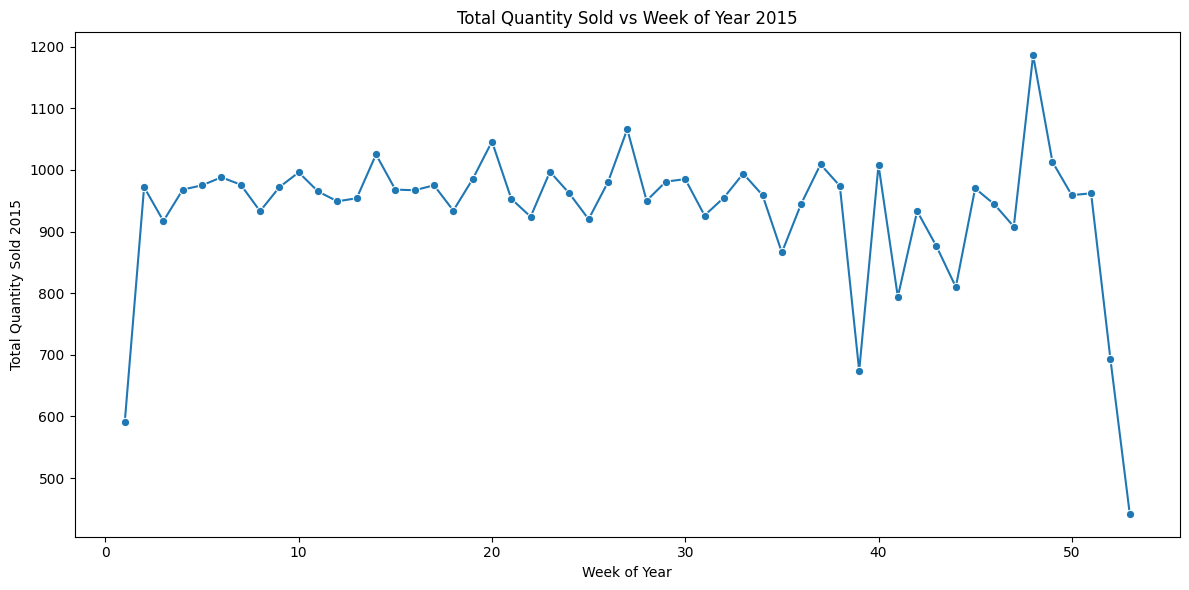

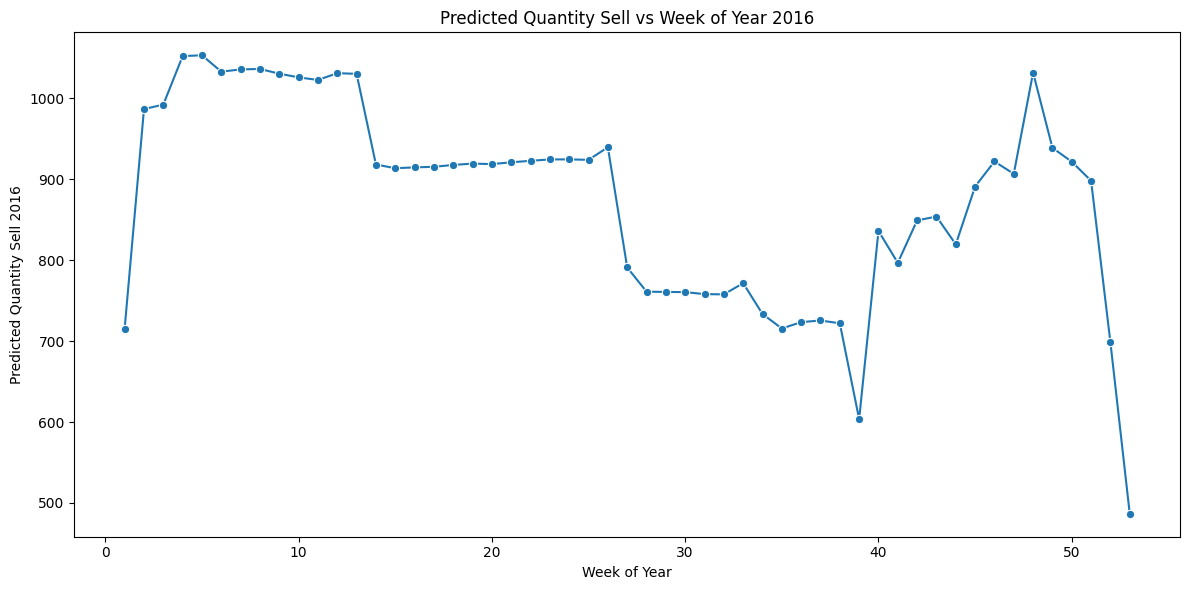

In [69]:
# Aggregate total quantity sold by week_of_year
weekly_sales = filtered_weekly_sales.groupby('week_of_year', as_index=False)['total_quantity_sold_W'].sum()

# Create a plot for 'total_quantity_sold_W' vs 'week_of_year'
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed for better readability
sns.lineplot(x='week_of_year', y='total_quantity_sold_W', data=weekly_sales, marker='o')

# Title and labels
plt.title('Total Quantity Sold vs Week of Year 2015')
plt.xlabel('Week of Year')
plt.ylabel('Total Quantity Sold 2015')

# Show the plot
plt.tight_layout()
plt.show()

# -------------

# Aggregate predicted quantity sold by week_of_year
weekly_predictions = merged_df_with_predictions.groupby('week_of_year', as_index=False)['predicted_quantity'].sum()

# Create a plot for 'predicted_quantity' vs 'week_of_year'
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed for better readability
sns.lineplot(x='week_of_year', y='predicted_quantity', data=weekly_predictions, marker='o')

# Title and labels
plt.title('Predicted Quantity Sell vs Week of Year 2016')
plt.xlabel('Week of Year')
plt.ylabel('Predicted Quantity Sell 2016')

# Show the plot
plt.tight_layout()
plt.show()


Total Quantity Sold vs. Week of Year (2015)
- The sales start low at around 600 in Week 1.
- From Week 2 to Week 38, sales increase and stabilize between 900 and 1,050 units.
- Week 39 sees a drop to around 650, but sales recover in Week 40, stabilizing again around 900–1,050 until Week 47.
- Week 48 peaks at 1,200, followed by a decline in the next few weeks, stabilizing around 950 until Week 51.
- Week 52 drops to 650, and Week 53 further declines to around 400.

Predicted Quantity Sold vs. Week of Year (2016)
- The year starts higher than 2015, at around 700 in Week 1.
- From Week 2 to Week 13, sales increase and stabilize around 1,000 units.
- Week 14 sees a drop, with sales stabilizing around 900 until Week 26.
- Week 27 marks another decline, with sales remaining between 700 and 780 until Week 38.
- Week 39 drops to 600, but Week 40 sees a recovery to 800, followed by a gradual increase until Week 48, reaching 1,000 units.
- Week 49 experiences a slight drop to 950, followed by a gradual decline to 900 in Week 51.
- Week 52 drops to 700, and Week 53 further declines to 500.

---
Gradient Boosting Machines (GBM) are powerful at capturing complex relationships and interactions within the data, even if they aren't explicitly defined. These models can learn patterns such as seasonality, consumer behavior trends, and feature interactions (like how week_of_year, price_category, and size interact to affect demand) without requiring external factors like weather or promotions.

Here's how GBM can capture these relationships:

- Handling Non-linear Relationships: GBM can model non-linear relationships. For instance, the relationship between the week of the year and the predicted quantity sold might not be linear, but GBM can capture these non-linear patterns through decision trees. It can identify the specific weeks where demand spikes and learn when and why these spikes occur.

- Interaction Between Features: GBM is great at capturing interactions between features. For example, it can learn how the combination of certain weeks and specific price categories influences predicted sales. If certain price points have a stronger effect on sales during certain weeks (like discounts around holidays), GBM can capture these interactions.

- Learning from Temporal or Cyclical Patterns: Although dataset doesn't directly include time series features like weather or promotions, GBM can still learn from patterns that emerge from the week_of_year or season columns. 

For example:

If certain types of pizzas (e.g., The Thai Chicken Pizza) are more popular in the summer, the model can learn this trend.

If demand for a pizza is generally higher in the week before holidays (e.g., week_of_year 51), the model will adapt to this.

- Feature Importance: GBM assigns importance scores to features based on how well they reduce errors during training. This means the model may give higher importance to features like week_of_year or season if they are strongly associated with variations in sales, allowing the model to use these patterns for predictions.

- Adaptive Learning: Gradient boosting works iteratively by adjusting predictions based on the errors made by previous trees. This allows the model to fine-tune its understanding of how certain weeks, sizes, or other factors influence the quantity sold over time. If the data shows certain seasonal effects or trends (like increased sales in certain weeks), the model will adapt to this and reflect it in the predictions.



Insights and Recommendations Based on the Analysis
1. Best-Selling and Least-Selling Pizzas:
- 2015: The best-selling pizza was The Classic Deluxe Pizza, followed by The BBQ Chicken Pizza, The Hawaiian Pizza, and The Pepperoni Pizza.
- 2016 (Predicted): The Pepperoni Pizza is expected to be the top seller, followed by The Classic Deluxe Pizza, The California Chicken Pizza, and The Thai Chicken Pizza.
- Least-Selling Pizza (Both Years): The Brie Carre Pizza consistently ranks as the lowest seller (~500 units).
  
2. Size Preferences
- 2015 & 2016: Customers prefer sizes in this order: L > M > S > XL > XXL

3. Holiday vs. Non-Holiday Sales
- 2015: Non-holiday weeks sold 2.7 times more than holiday weeks.
- 2016 (Predicted): Non-holiday weeks are expected to sell 2.2 times more than holiday weeks.

4. Seasonal Trends
- 2015: Sales were highest in Summer > Spring > Winter > Fall
- 2016 (Predicted): Expected to shift to Winter > Spring > Fall > Summer.

5. Price Category Preferences
- Both Years: The majority of sales come from Medium-priced pizzas ($15-$25), followed by Low-priced (<$15), with High-priced (> $25) being almost negligible (~500 units).

6. Weekly Sales Trends
- 2015: Sales were stable (~900–1050 units) but saw drops in Weeks 39, 52, and 53.
- 2016 (Predicted): Follows a similar trend but starts higher (~700 units), with a gradual decline in the second half of the year and drops in Weeks 39, 52, and 53.

7. Feature Importance & Predictive Insights
- Price (18.8%) – The strongest predictor, indicating that customers are highly price-sensitive.
- Week of Year (10.2%) – Suggests clear seasonal and weekly sales patterns.



Recommendation:
- Focus promotions on high-performing pizzas to drive even more sales.
- Promote the Brie Carre Pizza to assess customer demand. Since this pizza is currently available in only one size, analyze its sales performance after the promotion. If demand increases, consider introducing additional sizes or complementary offers. 
- Optimize inventory for Large and Medium pizzas since they are in high demand.
- Since 2016 predicts higher winter sales, consider launching winter-themed promotions (e.g., family bundles, seasonal flavors).
- Identify why summer sales are predicted to decline—adjust marketing efforts accordingly.
- Focus product strategy on the medium-priced segment, which performs best.
- Consider revising pricing strategy for high-priced pizzas—perhaps premium toppings or meal combos could justify the price.
- Weeks 39, 52, and 53 historically see sales drops—consider targeted marketing campaigns or discounts during these weeks to maintain volume.
- Monitor week-over-week performance closely to adjust inventory and promotions dynamically.

